# PROJECT - Microsoft : Classifying Cybersecurity Incidents with Machine Learning

**Problem Statement:**
Imagine you are working as a data scientist at Microsoft, tasked with enhancing the efficiency of Security Operation Centers (SOCs) by developing a machine learning model that can accurately predict the triage grade of cybersecurity incidents. Utilizing the comprehensive GUIDE dataset, your goal is to create a classification model that categorizes incidents as true positive (TP), benign positive (BP), or false positive (FP) based on historical evidence and customer responses. The model should be robust enough to support guided response systems in providing SOC analysts with precise, context-rich recommendations, ultimately improving the overall security posture of enterprise environments.



**Required libraries**

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn
# !pip install xgboost
# !pip install catboost
# !pip install optuna
# !pip install shap

# Imports and setup

In [55]:
# Data handling and manipulation
import numpy as np
import pandas as pd

# Data preprocessing and scaling
from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder, 
    StandardScaler,
    label_binarize
)

# Model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Model evaluation and metrics
from sklearn.metrics import (
    accuracy_score, 
    mean_squared_error, 
    r2_score, 
    f1_score, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    classification_report, 
    make_scorer
)

# Model selection and validation
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedShuffleSplit, 
    StratifiedKFold, 
    RandomizedSearchCV
)

# Class weight handling
from sklearn.utils.class_weight import compute_class_weight

# Data resampling
from sklearn.utils import resample

# Dimensionality reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter tuning library
import optuna
from sklearn.datasets import load_iris

import shap


**As we have a huge dataset, we will use less number of rows from Train dataset**<br><br>
*Note: This will be not used for our final model*

In [56]:
desired_rows = 1000000



# Pre-processing and Visualisation



In [57]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [58]:
df = pd.read_csv("../Data_sets/GUIDE_Train.csv", nrows=desired_rows, low_memory = True)
df.head()

C:\Users\RAJ\AppData\Local\Temp\ipykernel_11500\1145341303.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data_sets/GUIDE_Train.csv", nrows=desired_rows, low_memory = True)


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [59]:
null_percentage = df.isnull().mean() * 100
high_null_columns = null_percentage[null_percentage >= 70].index
high_null_columns_info = null_percentage[null_percentage >= 70]
print("Columns with 70% or more null values:")
print(high_null_columns_info)

Columns with 70% or more null values:
ActionGrouped        99.4200
ActionGranular       99.4200
EmailClusterId       98.9733
ThreatFamily         99.2230
ResourceType         99.9235
Roles                97.7147
AntispamDirection    98.1416
SuspicionLevel       84.8126
LastVerdict          76.4980
dtype: float64


In [60]:
drop_columns = high_null_columns
df = df.drop(columns=drop_columns)

In [61]:
missing_df = pd.DataFrame(df.isna().sum()).reset_index()
missing_df.columns = ['Column', 'Missing Values']
missing_df = missing_df[missing_df['Missing Values'] > 0]
print(missing_df)

            Column  Missing Values
8  MitreTechniques          574909
9    IncidentGrade            5289


In [62]:
print("Missing values in MitreTechniques Column: ",df['MitreTechniques'].isna().sum())
print("Non-Null Values in MitreTechniques Column: ",df['MitreTechniques'].count())
print("Percentage of Null Values in MitreTechniques Column: ",df['MitreTechniques'].isnull().mean() * 100)

Missing values in MitreTechniques Column:  574909
Non-Null Values in MitreTechniques Column:  425091
Percentage of Null Values in MitreTechniques Column:  57.4909


In [63]:
unique_values = set()
for techniques in df['MitreTechniques'].dropna():
    unique_values.update(techniques.split(';'))
unique_values_list = list(unique_values)
print("Unique values in MitreTechniques Column: ",len(unique_values_list))
print(unique_values_list)

Unique values in MitreTechniques Column:  396
['T1027.005', 'T1505.003', 'T1505.004', 'T1564.003', 'T1546.007', 'T1621', 'T1059', 'T1114.001', 'T1543.003', 'T1187', 'T1211', 'T0857', 'T1008', 'T1091', 'T1548.002', 'T1558.001', 'T1064', 'T1564.005', 'T1497.001', 'T1202', 'T1557', 'T1052', 'T0858', 'T1059.002', 'T1194', 'T1003.002', 'T1552.004', 'T1566.001', 'T1200', 'T1027.004', 'T1197', 'T1220', 'T1110.002', 'T1218.011', 'T1481', 'T1550.003', 'T1517', 'T1137.005', 'T1056.001', 'T1176', 'T1016.001', 'T1558.003', 'T1053', 'T1053.003', 'T1222.002', 'T1071.001', 'T1114', 'T1113', 'T1036.003', 'T1518.001', 'T1043', 'T0823', 'T1643', 'T1218.001', 'T1486', 'T1199', 'T1133', 'T1561.002', 'T1588', 'T1525', 'T1012', 'T1129', 'T1584.007', 'T1485', 'T1614.001', 'T1037', 'T1033', 'T1569', 'T1219', 'T1573', 'T1587', 'T0871', 'T1071', 'T1134.004', 'T1036.004', 'T1059.007', 'T1049', 'T1552.003', 'T1574.007', 'T1559.001', 'T1003.008', 'T1218.004', 'T1640', 'T1568', 'T1547.004', 'T1125', 'T1087', 'T1555

In [64]:
text = """
We have a individual list of values(ex. T1047;T1059;T1053;T1569) in Mitre Technique Column,
and we have 396 unique values, imputing with repeated values or any other method will not give us the correct results.
So, Dropping the MitreTechniques column.
    """
print(text)
df = df.drop(columns=['MitreTechniques'])


We have a individual list of values(ex. T1047;T1059;T1053;T1569) in Mitre Technique Column,
and we have 396 unique values, imputing with repeated values or any other method will not give us the correct results.
So, Dropping the MitreTechniques column.
    


In [65]:
display_all(df.head().T)

,0,1,2,3,4
Id,180388628218,455266534868,1056561957389,1279900258736,214748368522
OrgId,0,88,809,92,148
IncidentId,612,326,58352,32992,4359
AlertId,123247,210035,712507,774301,188041
Timestamp,2024-06-04T06:05:15.000Z,2024-06-14T03:01:25.000Z,2024-06-13T04:52:55.000Z,2024-06-10T16:39:36.000Z,2024-06-15T01:08:07.000Z
DetectorId,7,58,423,2,9
AlertTitle,6,43,298,2,74
Category,InitialAccess,Exfiltration,InitialAccess,CommandAndControl,Execution
IncidentGrade,TruePositive,FalsePositive,FalsePositive,BenignPositive,TruePositive
EntityType,Ip,User,Url,Url,User


In [66]:
counts = df['Category'].value_counts()
percentages = (df['Category'].value_counts(normalize=True) * 100).round(2)
combined = pd.concat([counts, percentages], axis=1)
combined.columns = ['Counts', 'Percentages']
combined

,Counts,Percentages
Category,,
InitialAccess,450177,45.02
Exfiltration,165858,16.59
SuspiciousActivity,106021,10.60
CommandAndControl,86494,8.65
Impact,79216,7.92
CredentialAccess,31676,3.17
Execution,28224,2.82
Malware,15094,1.51
Discovery,13686,1.37


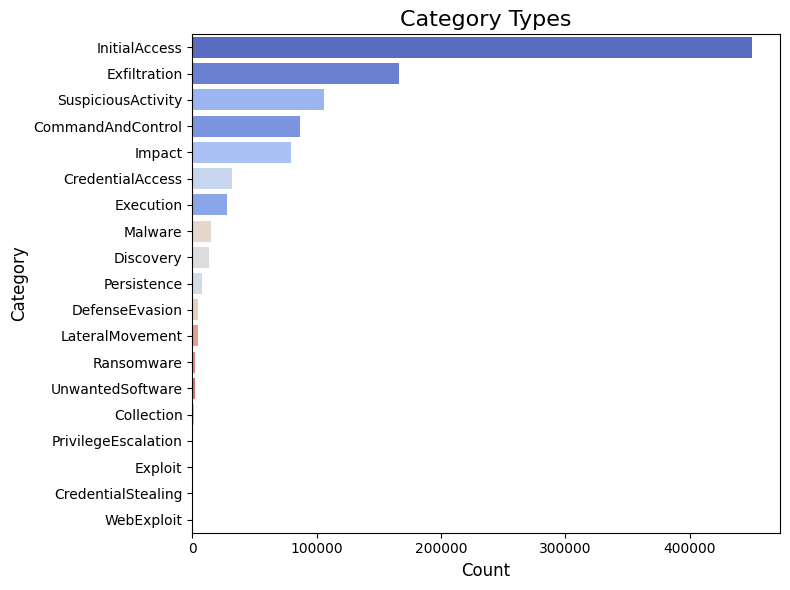

In [67]:
plt.figure(figsize=(8, 6))
sns.countplot(y='Category', data=df, hue='Category', palette='coolwarm', order=df['Category'].value_counts().index)
plt.title('Category Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()

In [68]:
groupings = {
    'Access': ['InitialAccess', 'CredentialAccess', 'PrivilegeEscalation', 'CredentialStealing'],
    'Malware': ['Malware', 'Ransomware', 'UnwantedSoftware', 'WebExploit', 'Exploit'],
    'Movement': ['Exfiltration', 'LateralMovement', 'Collection'],
    'Control': ['CommandAndControl', 'Execution', 'Persistence'],
    'Detection': ['SuspiciousActivity', 'Discovery', 'DefenseEvasion'],
    'Impact': ['Impact'] 
}

reverse_map = {cat: group for group, cats in groupings.items() for cat in cats}
df['Category'] = df['Category'].map(lambda x: reverse_map.get(x, 'Other'))

df['Category'].value_counts()

Category
Access       482385
Movement     171842
Detection    124625
Control      122390
Impact        79216
Malware       19542
Name: count, dtype: int64

In [69]:
df['IncidentGrade'].unique()

array(['TruePositive', 'FalsePositive', 'BenignPositive', nan],
      dtype=object)

In [70]:
print("Counts of IncidentGrade Column")
print(df['IncidentGrade'].value_counts())

Counts of IncidentGrade Column
IncidentGrade
BenignPositive    431466
TruePositive      349502
FalsePositive     213743
Name: count, dtype: int64


In [71]:
incident_grade_counts = df['IncidentGrade'].value_counts()
benign_positive_percentage = round(incident_grade_counts.iloc[0] / len(df) * 100, 2)
print('Benign Positive', benign_positive_percentage, '% of the dataset')

true_positive_percentage = round(incident_grade_counts.iloc[1] / len(df) * 100, 2)
print('True Positive', true_positive_percentage, '% of the dataset')

false_positive_percentage = round(incident_grade_counts.iloc[2] / len(df) * 100, 2)
print('False Positive', false_positive_percentage, '% of the dataset')

Benign Positive 43.15 % of the dataset
True Positive 34.95 % of the dataset
False Positive 21.37 % of the dataset


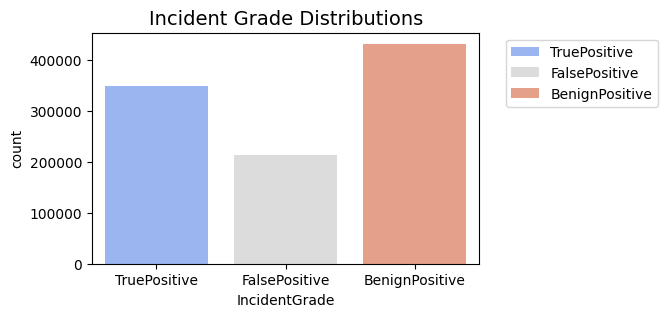

In [72]:
plt.figure(figsize=(5, 3))
sns.countplot(x='IncidentGrade', data=df, hue='IncidentGrade', palette='coolwarm')
plt.title('Incident Grade Distributions', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [73]:
def plot_top_counts(df, category_col, top_n=20, log_scale=True):
    
    df_counts = df[category_col].value_counts().reset_index()
    df_counts.columns = [category_col, 'Count']  # Rename columns
    df_sorted = df_counts.head(top_n)  # Get top N categories

    # Set figure size
    plt.figure(figsize=(12, 6))

    # Use a color gradient
    colors = sns.color_palette("viridis", len(df_sorted))

    # Create bar plot
    plt.bar(df_sorted[category_col].astype(str), df_sorted['Count'], color=colors)

    # Apply log scale if required
    if log_scale:
        plt.yscale('log')

    # Titles and labels
    plt.title(f'Top {top_n} {category_col} by Count (Log Scale)' if log_scale else f'Top {top_n} {category_col} by Count', 
              pad=20, size=14)
    plt.xlabel(category_col, labelpad=10)
    plt.ylabel('Count (log scale)' if log_scale else 'Count', labelpad=10)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45, ha='right')

    # Add grid
    plt.grid(True, which="both", linestyle="-", alpha=0.3)

    # Annotate top 5 values
    for i, val in enumerate(df_sorted['Count'].values[:5]):  # Top 5 only
        plt.text(i, val, f"{val:,}", ha='center', va='bottom', fontsize=10, color='black')

    # Adjust layout for better fit
    plt.tight_layout()

    # Show the plot
    plt.show()

In [74]:
df['CountryCode'].value_counts()

CountryCode
242    921418
0       18172
1       11221
2        5665
4        4343
        ...  
167         1
198         1
151         1
163         1
181         1
Name: count, Length: 166, dtype: int64

In [75]:
df['State'].value_counts()

State
1445    933665
0        10942
1         4249
2         3111
3         2393
         ...  
1383         1
491          1
915          1
657          1
510          1
Name: count, Length: 788, dtype: int64

In [76]:
df['City'].value_counts()

City
10630    933602
0         10892
1          2369
2          2072
3          1584
          ...  
5960          1
5583          1
7515          1
9278          1
4305          1
Name: count, Length: 3191, dtype: int64

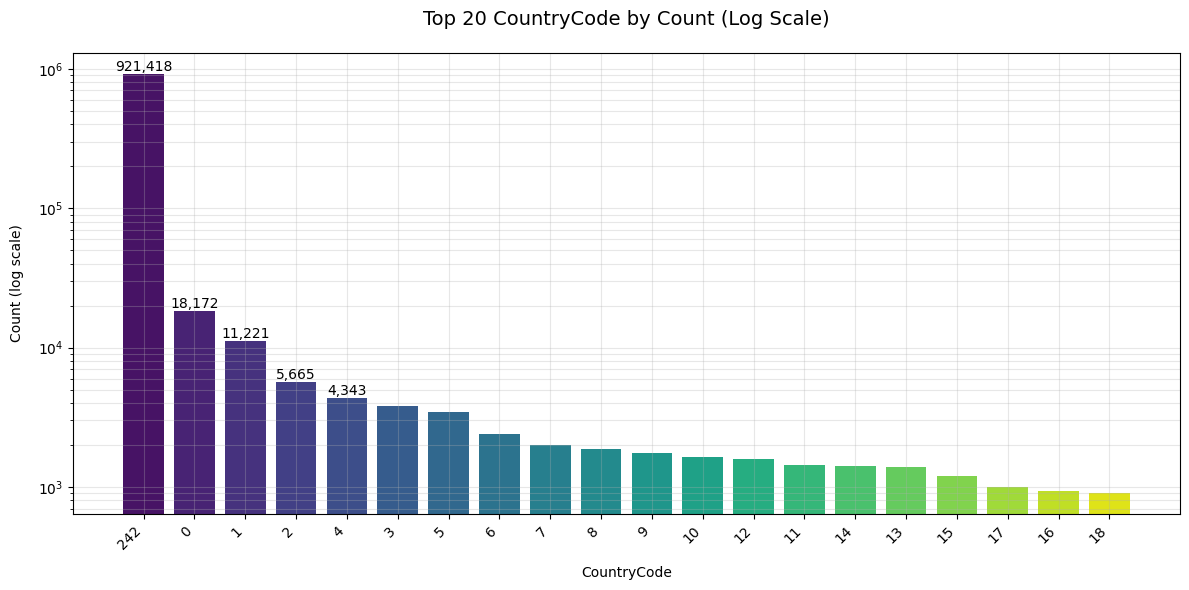

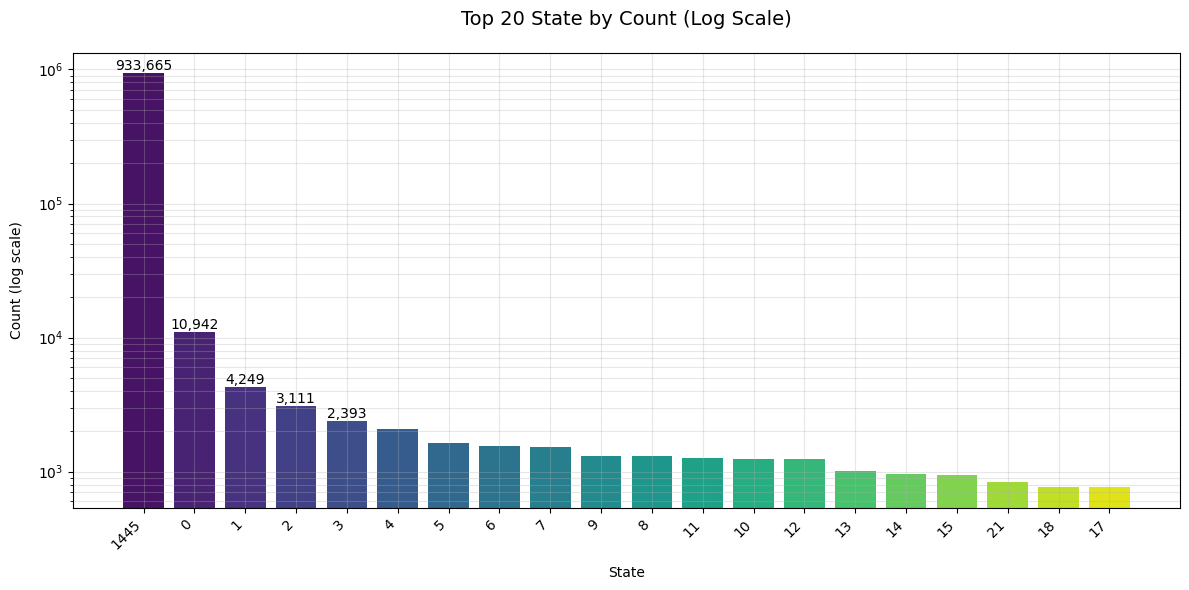

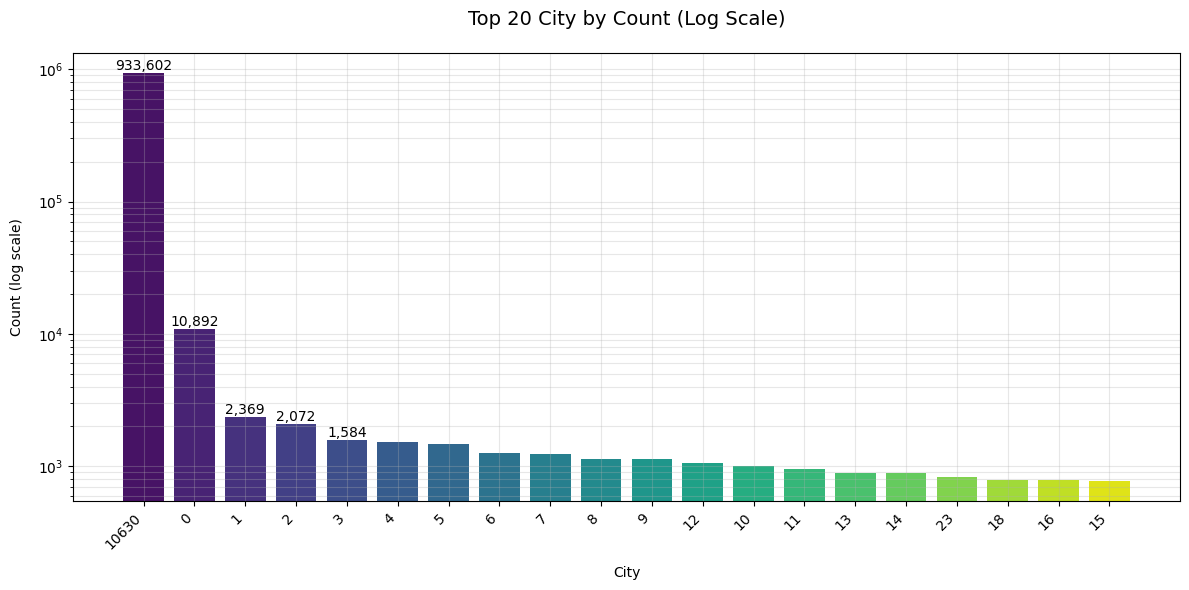

In [77]:
plot_top_counts(df, category_col='CountryCode')

plot_top_counts(df, category_col='State')

plot_top_counts(df, category_col='City')

In [78]:
def group_categorical_column(df, column_name):
    value_counts = df[column_name].value_counts().reset_index()
    value_counts.columns = [column_name, "count"]

    bins = [0, 100, 1000, 2000, 5000, 10000, 20000, float('inf')]
    labels = ["0-100", "100-1000", "1000-2000", "2000-5000", "5000-10000", "10000-20000", "20000+"]

    value_counts["Group"] = pd.cut(value_counts["count"], bins=bins, labels=labels, right=False)

    df = df.merge(value_counts[[column_name, "Group"]], on=column_name, how="left")

    df[column_name] = df["Group"]

    df.drop(columns=["Group"], inplace=True)

    return df

In [79]:
group_cols = ['CountryCode','State', 'City']

for col in group_cols:
    df = group_categorical_column(df, col)

oe = OneHotEncoder(sparse_output=False)
for column in group_cols:
    encoded_data = oe.fit_transform(df[[column]])
    encoded_cols = [f"{column}_{cat}" for cat in oe.categories_[0]]
    df[encoded_cols] = encoded_data
    df.drop(columns=[column], inplace=True)


In [80]:
df['EntityType'].unique()

array(['Ip', 'User', 'Url', 'MailMessage', 'Process', 'Machine',
       'CloudApplication', 'AzureResource', 'File', 'Mailbox',
       'CloudLogonRequest', 'MailCluster', 'Malware', 'CloudLogonSession',
       'OAuthApplication', 'RegistryValue', 'SecurityGroup',
       'RegistryKey', 'GenericEntity', 'ActiveDirectoryDomain',
       'BlobContainer', 'Blob', 'MailboxConfiguration', 'IoTDevice',
       'AmazonResource', 'Nic', 'Container', 'GoogleCloudResource'],
      dtype=object)

In [81]:
counts = df['EntityType'].value_counts()
percentages = (df['EntityType'].value_counts(normalize=True) * 100).round(2)
combined = pd.concat([counts, percentages], axis=1)
combined.columns = ['Counts', 'Percentages']
combined

,Counts,Percentages
EntityType,,
Ip,229086,22.91
User,203470,20.35
MailMessage,123212,12.32
Machine,73133,7.31
Url,72032,7.20
File,71853,7.19
CloudLogonRequest,67070,6.71
Mailbox,50654,5.07
Process,36428,3.64


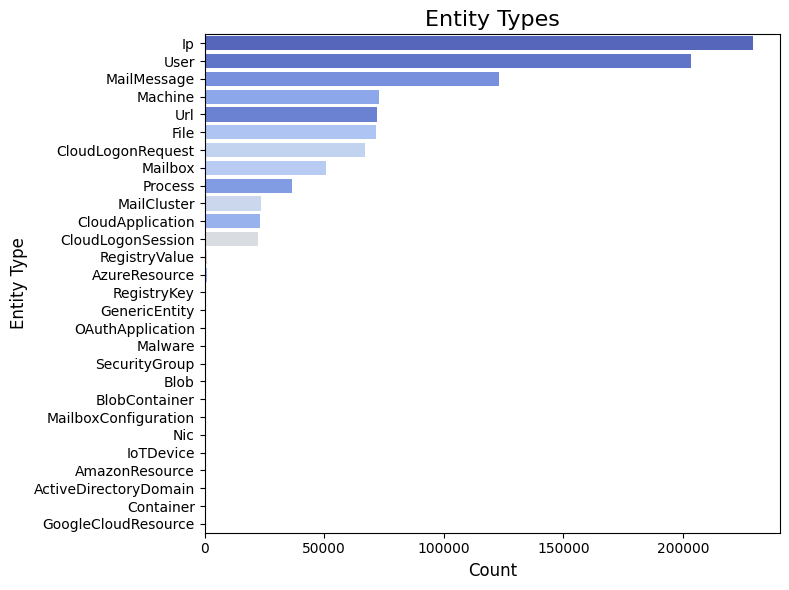

In [82]:
plt.figure(figsize=(8, 6))
sns.countplot(y='EntityType', data=df, hue='EntityType', palette='coolwarm', order=df['EntityType'].value_counts().index)
plt.title('Entity Types', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Entity Type', fontsize=12)
plt.tight_layout()
plt.show()

In [83]:
groupings = {
    'Identity': ['User', 'Mailbox', 'SecurityGroup'],
    'Network': ['Ip', 'Url', 'Nic'],
    'FileSystem': ['File', 'RegistryValue', 'RegistryKey', 'Blob', 'BlobContainer'],
    'Cloud': ['CloudLogonRequest', 'CloudLogonSession', 'CloudApplication', 'AzureResource', 
              'AmazonResource', 'GoogleCloudResource', 'OAuthApplication'],
    'Machine': ['Machine', 'Process', 'IoTDevice', 'Container'],
    'Email': ['MailMessage', 'MailCluster', 'MailboxConfiguration'],
    'Malware': ['Malware'],
    'Other': ['GenericEntity', 'ActiveDirectoryDomain']
}

reverse_map = {cat: group for group, cats in groupings.items() for cat in cats}
df['EntityType'] = df['EntityType'].map(lambda x: reverse_map.get(x, 'Other'))

df['EntityType'].value_counts()
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,State_1000-2000,State_10000-20000,State_2000-5000,State_20000+,City_0-100,City_100-1000,City_1000-2000,City_10000-20000,City_2000-5000,City_20000+
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,Access,TruePositive,Network,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Movement,FalsePositive,Identity,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,Access,FalsePositive,Network,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,Control,BenignPositive,Network,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Control,TruePositive,Identity,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


**Creating Weekday and Hour Column from timestamp column to analyse Incidents based on Timeline**

In [84]:
df_copy = df.copy()
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Incident_Hour'] = df['Timestamp'].dt.hour
df['Incident_day_of_week'] = df['Timestamp'].dt.dayofweek
df.drop(columns=['Timestamp'], inplace=True)

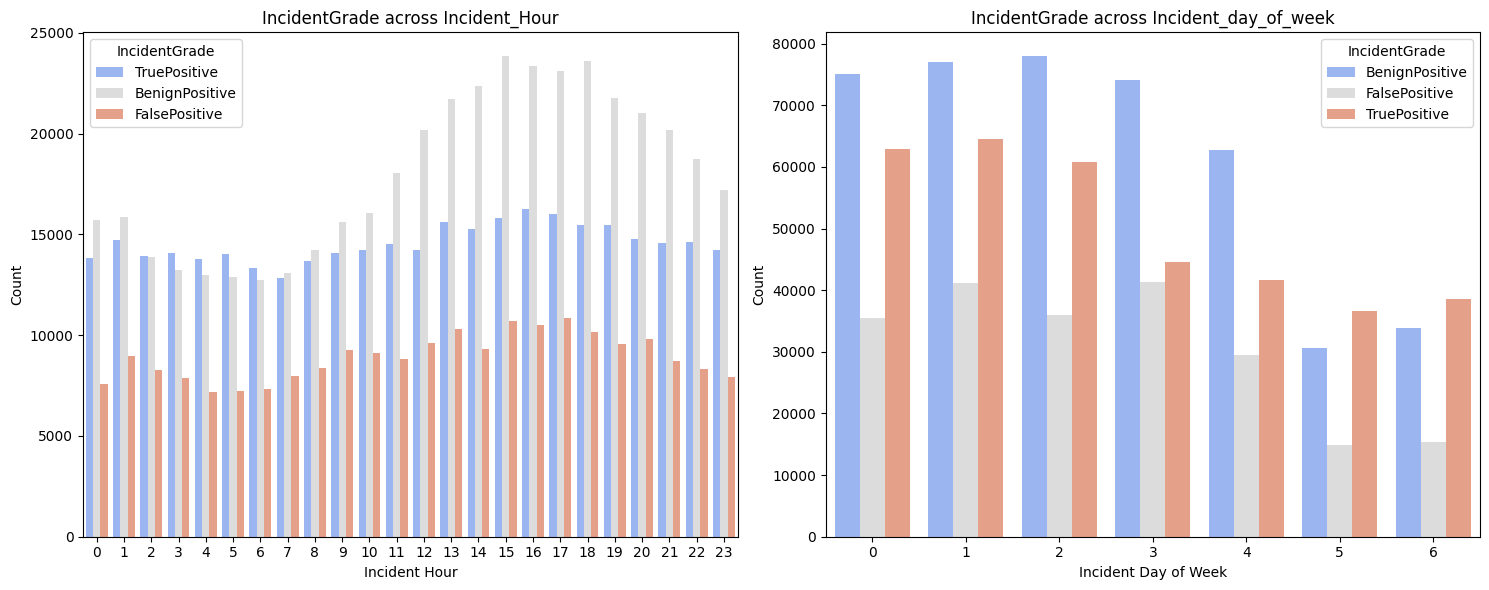

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# IncidentGrade distribution by Incident_Hour in the first subplot
sns.countplot(x='Incident_Hour', hue='IncidentGrade', palette='coolwarm', data=df, ax=axes[0])
axes[0].set_title('IncidentGrade across Incident_Hour')
axes[0].set_xlabel('Incident Hour')
axes[0].set_ylabel('Count')

# IncidentGrade distribution by Incident_day_of_week in the second subplot
sns.countplot(x='Incident_day_of_week', hue='IncidentGrade', palette='coolwarm', data=df, ax=axes[1])
axes[1].set_title('IncidentGrade across Incident_day_of_week')
axes[1].set_xlabel('Incident Day of Week')
axes[1].set_ylabel('Count')

plt.tight_layout()

# Show the plot
plt.show()

Clearly we can see a increasing pattern in incidents.</br>
In Incidents by Hour of Day, we can see that the incidents are increasing from 9 AM to Midnight.</br>
In Incidents by Day of Week, we can see that the incidents are increasing from Sunday to Wednesday.

# Evaluating with Imputing null values in Target Columns with random forest

In [86]:
def label_encoder(df, column):
    le = LabelEncoder()
    non_null_values = df[column].dropna()
    # Fit and transform only the non-null values
    df.loc[non_null_values.index, column] = le.fit_transform(non_null_values)
    return df

def one_hot_encoder(df, column):
    oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_data = oe.fit_transform(df[[column]])
    encoded_cols = [f"{column}_{cat}" for cat in oe.categories_[0]]
    df[encoded_cols] = encoded_data
    df.drop(columns=[column], inplace=True)    
    return df


def impute_missing_values(df, target_column, feature_columns, model_type="classification"):
    """
    Fills missing values in the target_column based on related feature_columns.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - target_column (str): The column with missing values to fill.
    - feature_columns (list): List of columns to use as predictors for filling missing values.
    - model_type (str): Type of model to use, "classification" for discrete values (e.g., month)
                        or "regression" for continuous values (e.g., years).

    Returns:
    - DataFrame with missing values in target_column filled.
    """
    # Separate data into rows with and without missing target_column values
    known_data = df.dropna(subset=[target_column])
    unknown_data = df[df[target_column].isnull()]

    if known_data.empty or unknown_data.empty:
        print(f"No missing values in {target_column} or no non-missing data for training.")
        return df

    # Set up predictors and target variable
    X = known_data[feature_columns]
    y = known_data[target_column]

    # Train/test split for model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Train the model
    model.fit(X_train, y_train)

    # Optional: Model Evaluation
    if model_type == "classification":
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Model accuracy for {target_column} imputation: {accuracy:.2f}")
        print(f"Model f1 score for {target_column} imputation: {f1:.2f}")

    # Impute missing values in the target column
    df.loc[unknown_data.index, target_column] = model.predict(unknown_data[feature_columns])

    return df


In [87]:
# Copy 1: For encoding and ML processing
df_encoded = df.copy()

# Copy 2: For storing imputed values
df_imputed = df.copy()

columns_to_encode = ['Category', 'EntityType', 'EvidenceRole', 'AlertTitle', 'DetectorId']

for column in columns_to_encode:
  if df_encoded[column].dtype == 'object':
    df_encoded = label_encoder(df_encoded, column)

df_encoded = impute_missing_values( df_encoded, target_column='IncidentGrade', feature_columns=['Category', 'EntityType', 'EvidenceRole', 'AlertTitle', 'DetectorId'],
    model_type='classification')

for column in df.columns:
    if column in df_encoded.columns:
        # Replace nulls in df_imputed with values from df_encoded
        df_imputed[column] = df_imputed[column].combine_first(df_encoded[column])

# Saving to original df
df = df_imputed

# Deleting variables
del df_encoded
del df_imputed

Model accuracy for IncidentGrade imputation: 0.79
Model f1 score for IncidentGrade imputation: 0.78


Accuracy and f1 score for IncidentGrade imputation is **0.79**

In [88]:
display_all(df.head())

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode_0-100,CountryCode_100-1000,CountryCode_1000-2000,CountryCode_10000-20000,CountryCode_2000-5000,CountryCode_20000+,CountryCode_5000-10000,State_0-100,State_100-1000,State_1000-2000,State_10000-20000,State_2000-5000,State_20000+,City_0-100,City_100-1000,City_1000-2000,City_10000-20000,City_2000-5000,City_20000+,Incident_Hour,Incident_day_of_week
0,180388628218,0,612,123247,7,6,Access,TruePositive,Network,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6,1
1,455266534868,88,326,210035,58,43,Movement,FalsePositive,Identity,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,4
2,1056561957389,809,58352,712507,423,298,Access,FalsePositive,Network,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4,3
3,1279900258736,92,32992,774301,2,2,Control,BenignPositive,Network,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,16,0
4,214748368522,148,4359,188041,9,74,Control,TruePositive,Identity,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,5


In [89]:
cols_to_drop = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'Incident_Hour', 'Incident_day_of_week']
df = df.drop(columns=cols_to_drop)

le_cols = ['IncidentGrade']
categorical_columns = [column for column in df.columns if df[column].dtype == 'object' and column not in le_cols]

le = LabelEncoder()
for column in le_cols:
    df[column] = le.fit_transform(df[column])

oe = OneHotEncoder(sparse_output=False)
df = pd.concat([df, pd.DataFrame(oe.fit_transform(df[categorical_columns]),
                                 columns=oe.get_feature_names_out(categorical_columns))], axis=1)

df = df.drop(columns=categorical_columns)

In [90]:
display_all(df.head())

,DetectorId,AlertTitle,IncidentGrade,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode_0-100,CountryCode_100-1000,CountryCode_1000-2000,CountryCode_10000-20000,CountryCode_2000-5000,CountryCode_20000+,CountryCode_5000-10000,State_0-100,State_100-1000,State_1000-2000,State_10000-20000,State_2000-5000,State_20000+,City_0-100,City_100-1000,City_1000-2000,City_10000-20000,City_2000-5000,City_20000+,Category_Access,Category_Control,Category_Detection,Category_Impact,Category_Malware,Category_Movement,EntityType_Cloud,EntityType_Email,EntityType_FileSystem,EntityType_Identity,EntityType_Machine,EntityType_Malware,EntityType_Network,EntityType_Other,EvidenceRole_Impacted,EvidenceRole_Related
0,7,6,2,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,58,43,1,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,423,298,1,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,2,2,0,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,9,74,2,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [91]:
print(df.columns)

Index(['DetectorId', 'AlertTitle', 'IncidentGrade', 'DeviceId', 'Sha256',
       'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
       'AccountName', 'DeviceName', 'NetworkMessageId', 'RegistryKey',
       'RegistryValueName', 'RegistryValueData', 'ApplicationId',
       'ApplicationName', 'OAuthApplicationId', 'FileName', 'FolderPath',
       'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode_0-100',
       'CountryCode_100-1000', 'CountryCode_1000-2000',
       'CountryCode_10000-20000', 'CountryCode_2000-5000',
       'CountryCode_20000+', 'CountryCode_5000-10000', 'State_0-100',
       'State_100-1000', 'State_1000-2000', 'State_10000-20000',
       'State_2000-5000', 'State_20000+', 'City_0-100', 'City_100-1000',
       'City_1000-2000', 'City_10000-20000', 'City_2000-5000', 'City_20000+',
       'Category_Access', 'Category_Control', 'Category_Detection',
       'Category_Impact', 'Category_Malware', 'Category_Movement',
       'EntityType_Cloud', 'Entity

In [92]:
X = df.drop(["IncidentGrade"], axis=1)
y = df["IncidentGrade"]

Finding Optimal feature number for model using *PCA*

In [93]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [94]:
def best_classification_model(x, y, models):
    # Check for shape mismatch
    if x.shape[0] != y.shape[0]:
        raise ValueError(f"Inconsistent number of samples: X has {x.shape[0]}, but y has {y.shape[0]}")

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

    # Binarize the labels for multiclass ROC/AUC
    classes = np.unique(y)
    y_test_binarized = label_binarize(y_test, classes=classes) if len(classes) > 2 else y_test

    results = []

    # Iterate over the models
    for model in models:
        # Get model name
        model_name = model.__class__.__name__
        print(f"Processing model: {model_name}")

        # Train the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test) if hasattr(model, 'predict_proba') else None

        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)

        # Compute ROC AUC for multiclass if probabilities are available
        roc_auc = None
        if y_pred_prob is not None and len(classes) > 2:
            roc_auc = {}
            for i, class_label in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
                roc_auc[class_label] = auc(fpr, tpr)
        elif y_pred_prob is not None:  # Binary classification
            fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
            roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "model": model_name,
            "Accuracy": acc,
            "ROC AUC": roc_auc
        })
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()
        # Plot ROC curve for multiclass if applicable
        if roc_auc and len(classes) > 2:
            plt.figure(figsize=(8, 6))
            for i, class_label in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
                plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')
            plt.plot([0, 1], [0, 1], color='red', linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Multiclass ROC Curve for {model_name}')
            plt.legend(loc='lower right')
            plt.show()

        # Classification report
        print(f"Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred))

        # Training and testing scores
        print(f"Train Score: {model.score(x_train, y_train):.2f}")
        print(f"Test Score: {model.score(x_test, y_test):.2f}")
        print("\n")
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.round(2)
    print("\nModel Performance Comparison:\n", results_df)
    # Identify best model based on accuracy
    best_model_idx = results_df['Accuracy'].idxmax()
    best_model = models[best_model_idx]

    return results_df, best_model

**Predicting with different models and comparing their performance**

Processing model: LogisticRegression


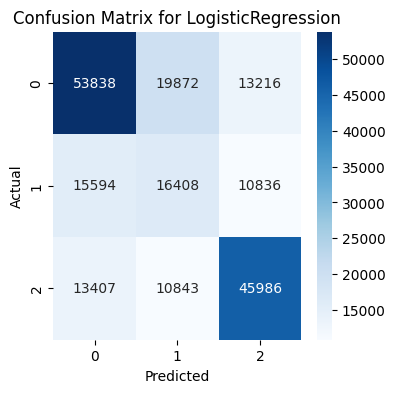

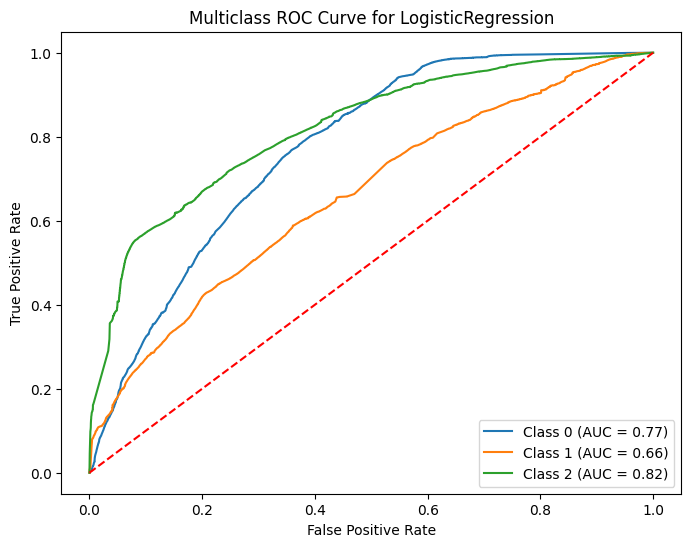

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.65      0.62      0.63     86926
           1       0.35      0.38      0.36     42838
           2       0.66      0.65      0.66     70236

    accuracy                           0.58    200000
   macro avg       0.55      0.55      0.55    200000
weighted avg       0.59      0.58      0.58    200000

Train Score: 0.58
Test Score: 0.58


Processing model: DecisionTreeClassifier


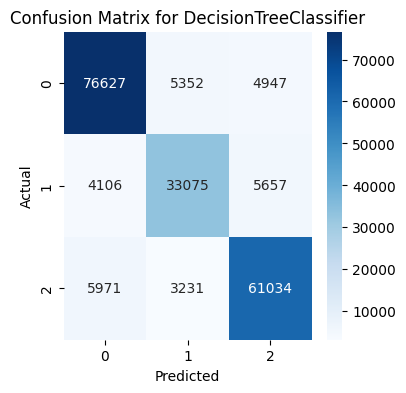

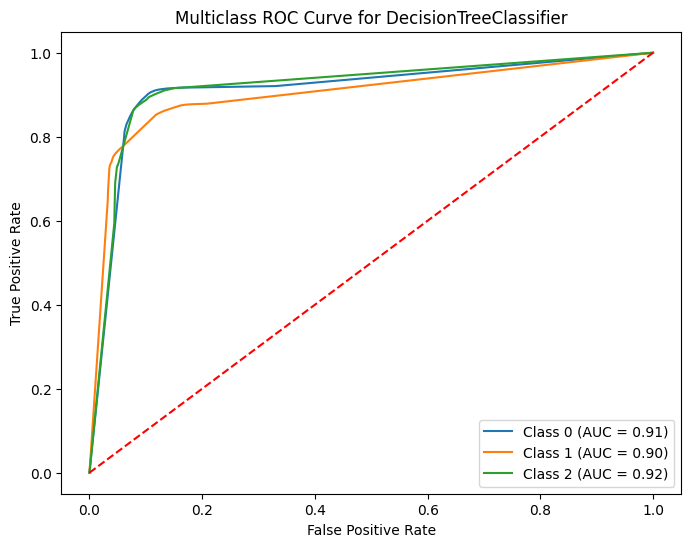

Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     86926
           1       0.79      0.77      0.78     42838
           2       0.85      0.87      0.86     70236

    accuracy                           0.85    200000
   macro avg       0.84      0.84      0.84    200000
weighted avg       0.85      0.85      0.85    200000

Train Score: 0.94
Test Score: 0.85


Processing model: RandomForestClassifier


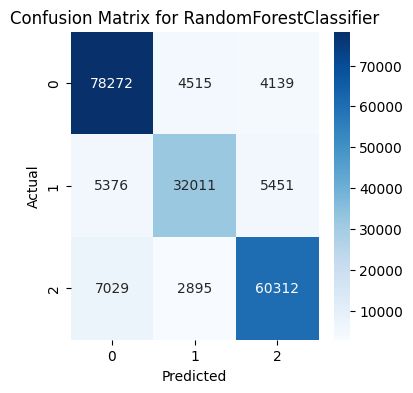

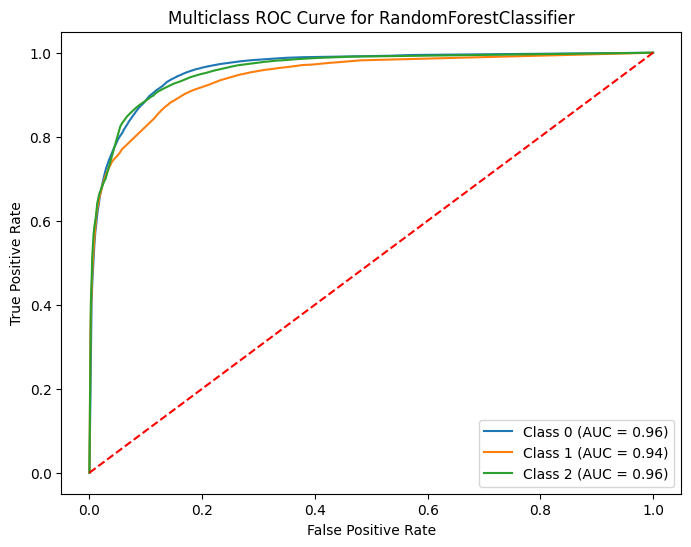

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     86926
           1       0.81      0.75      0.78     42838
           2       0.86      0.86      0.86     70236

    accuracy                           0.85    200000
   macro avg       0.85      0.84      0.84    200000
weighted avg       0.85      0.85      0.85    200000

Train Score: 0.94
Test Score: 0.85


Processing model: XGBClassifier


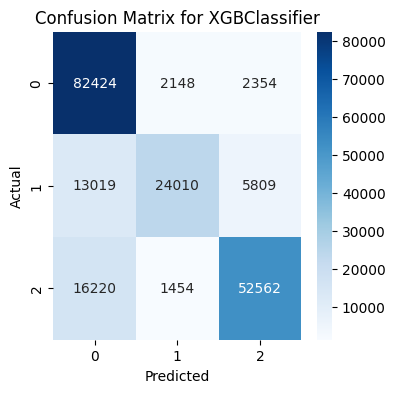

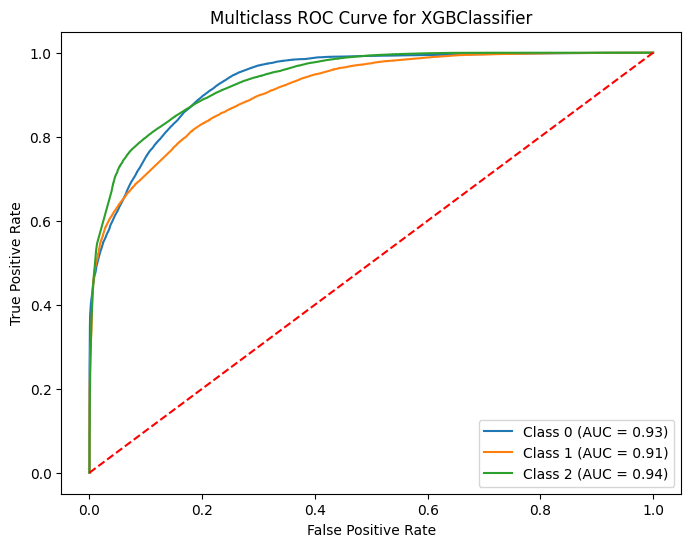

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.74      0.95      0.83     86926
           1       0.87      0.56      0.68     42838
           2       0.87      0.75      0.80     70236

    accuracy                           0.79    200000
   macro avg       0.82      0.75      0.77    200000
weighted avg       0.81      0.79      0.79    200000

Train Score: 0.80
Test Score: 0.79


Processing model: CatBoostClassifier


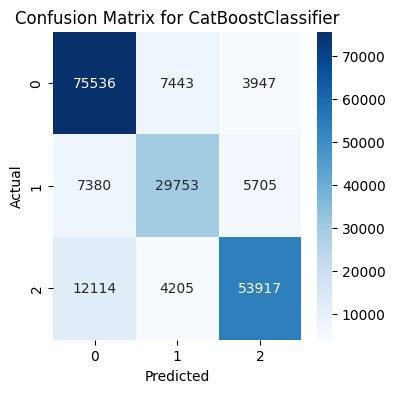

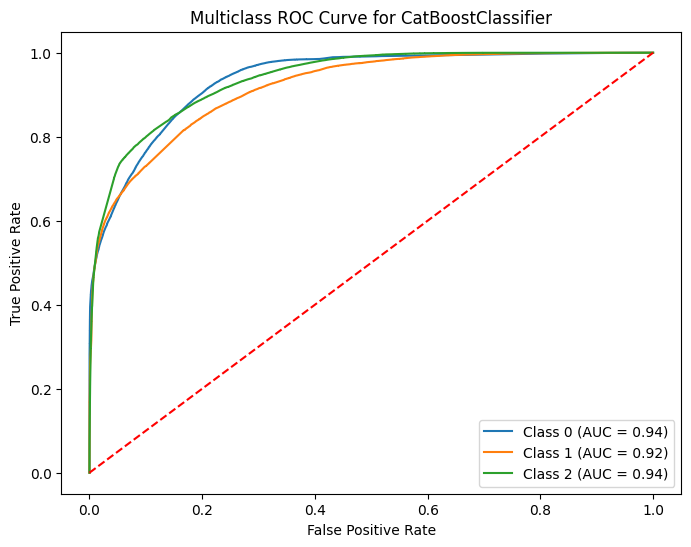

Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     86926
           1       0.72      0.69      0.71     42838
           2       0.85      0.77      0.81     70236

    accuracy                           0.80    200000
   macro avg       0.79      0.78      0.78    200000
weighted avg       0.80      0.80      0.80    200000

Train Score: 0.80
Test Score: 0.80



Model Performance Comparison:
                     model  Accuracy  \
0      LogisticRegression      0.58   
1  DecisionTreeClassifier      0.85   
2  RandomForestClassifier      0.85   
3           XGBClassifier      0.79   
4      CatBoostClassifier      0.80   

                                             ROC AUC  
0  {0: 0.7726642775587027, 1: 0.6598962507444753,...  
1  {0: 0.9120522249902212, 1: 0.9008500691729673,...  
2  {0: 0.9617517112038172, 1: 0.9440360367068061,...  
3  {0: 0.9337426136673023, 1: 0.9105467052199279

In [95]:
# Calculate class weights for a multiclass target
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

models = [
    LogisticRegression(class_weight='balanced', random_state=42),
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    XGBClassifier(objective='multi:softprob',num_class=len(np.unique(y)),random_state=42),
    CatBoostClassifier(auto_class_weights='Balanced', random_state=42, loss_function='MultiClass', verbose=0),
]

results_df, best_model = best_classification_model(X_scaled, y, models)

# Evaluating with dropping the null values in Target Column

In [36]:
def preprocess_data(df, target_col, drop_cols):
    # Use inplace operations where possible
    # Create views instead of copies
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # Clean target variable inplace
    y.replace({'': np.nan, 'None': np.nan, 'NULL': np.nan}, inplace=True)

    # Filter valid rows without creating intermediary objects
    mask = ~y.isna()
    X = X[mask]
    y = y[mask]

    # Drop specified columns inplace
    X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)

    # Identify column types once
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    if len(categorical_cols) > 0:
        # Process categorical columns in chunks if needed
        chunk_size = 100  # Adjust based on your memory constraints
        encoded_dfs = []

        for i in range(0, len(categorical_cols), chunk_size):
            chunk_cols = categorical_cols[i:i + chunk_size]
            oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

            # Transform in smaller chunks
            chunk_encoded = oe.fit_transform(X[chunk_cols])
            chunk_df = pd.DataFrame(
                chunk_encoded,
                columns=oe.get_feature_names_out(chunk_cols),
                index=X.index
            )
            encoded_dfs.append(chunk_df)

        # Concatenate all encoded chunks
        encoded_df = pd.concat(encoded_dfs, axis=1)

        # Drop original categorical columns and join encoded ones
        X.drop(columns=categorical_cols, inplace=True)
        X = pd.concat([X, encoded_df], axis=1)

        # Clear memory
        del encoded_dfs, encoded_df

    # Encode target variable
    le_target = LabelEncoder()
    y = pd.Series(le_target.fit_transform(y), index=X.index)

    # Handle remaining nulls
    mask = ~X.isna().any(axis=1)
    X = X[mask]
    y = y[mask]

    return X, y

In [37]:
null_percentage = df_copy.isnull().mean() * 100
high_null_columns = null_percentage[null_percentage >= 70].index
df_copy = df_copy.drop(columns=high_null_columns)

In [38]:
drop_cols=['Timestamp', 'Unnamed: 0', 'MitreTechniques']
X, y = preprocess_data(df_copy,target_col='IncidentGrade',drop_cols=drop_cols)
X.shape

(994711, 62)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Original shape: {X_scaled.shape}")

Original shape: (994711, 62)


Processing model: LogisticRegression


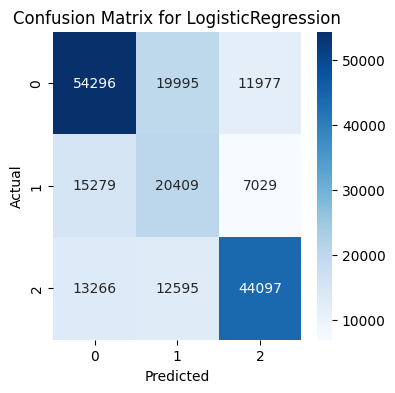

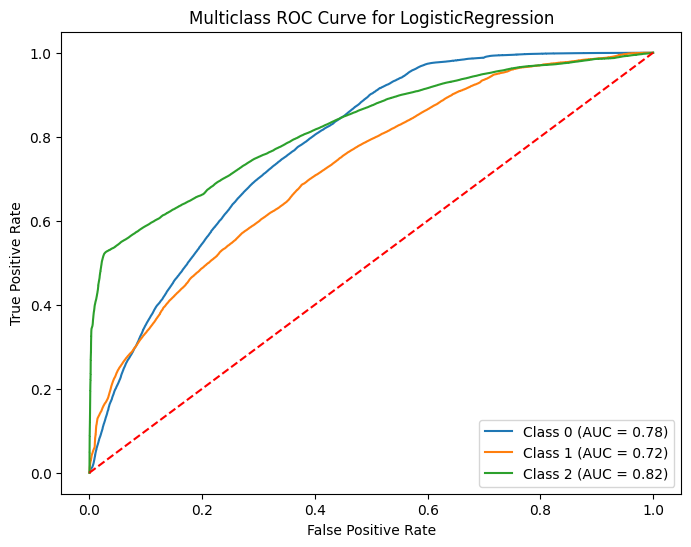

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.66      0.63      0.64     86268
           1       0.39      0.48      0.43     42717
           2       0.70      0.63      0.66     69958

    accuracy                           0.60    198943
   macro avg       0.58      0.58      0.58    198943
weighted avg       0.61      0.60      0.60    198943

Train Score: 0.60
Test Score: 0.60


Processing model: DecisionTreeClassifier


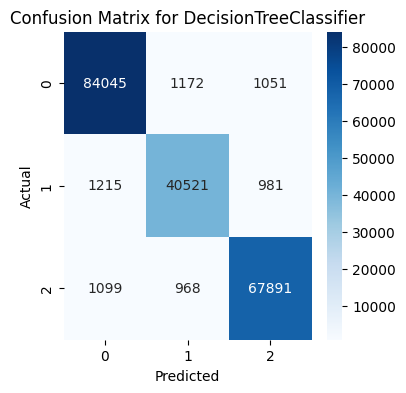

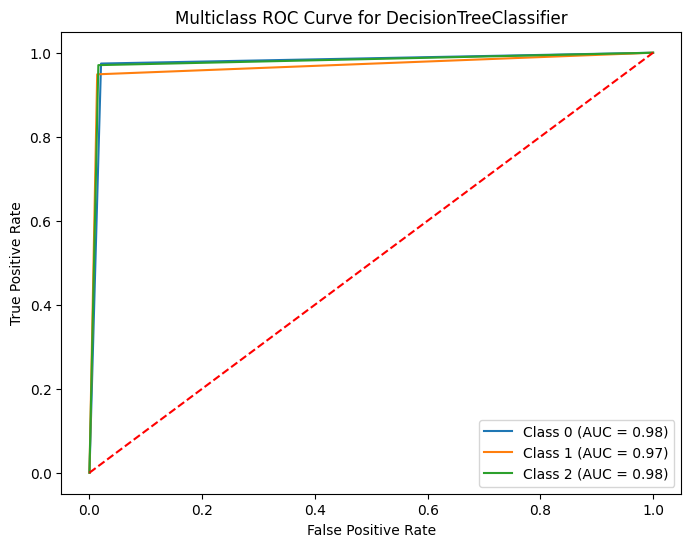

Classification Report for DecisionTreeClassifier:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     86268
           1       0.95      0.95      0.95     42717
           2       0.97      0.97      0.97     69958

    accuracy                           0.97    198943
   macro avg       0.96      0.96      0.96    198943
weighted avg       0.97      0.97      0.97    198943

Train Score: 1.00
Test Score: 0.97


Processing model: RandomForestClassifier


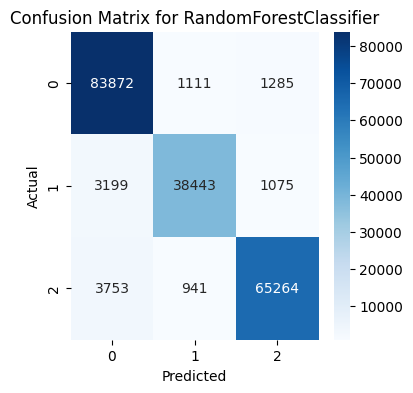

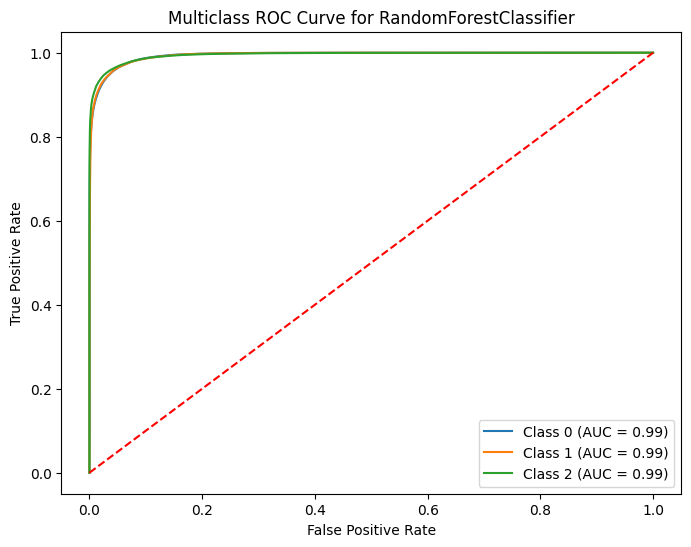

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     86268
           1       0.95      0.90      0.92     42717
           2       0.97      0.93      0.95     69958

    accuracy                           0.94    198943
   macro avg       0.95      0.94      0.94    198943
weighted avg       0.94      0.94      0.94    198943

Train Score: 1.00
Test Score: 0.94


Processing model: XGBClassifier


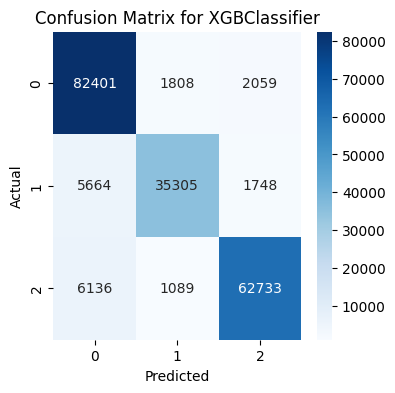

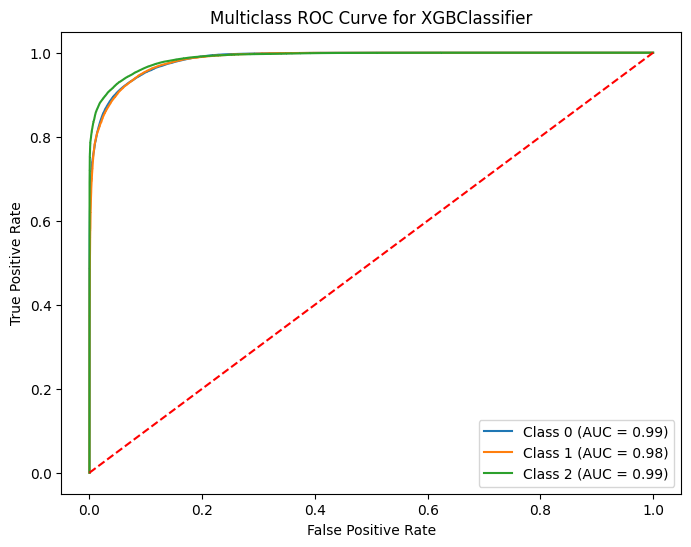

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     86268
           1       0.92      0.83      0.87     42717
           2       0.94      0.90      0.92     69958

    accuracy                           0.91    198943
   macro avg       0.91      0.89      0.90    198943
weighted avg       0.91      0.91      0.91    198943

Train Score: 0.91
Test Score: 0.91


Processing model: CatBoostClassifier


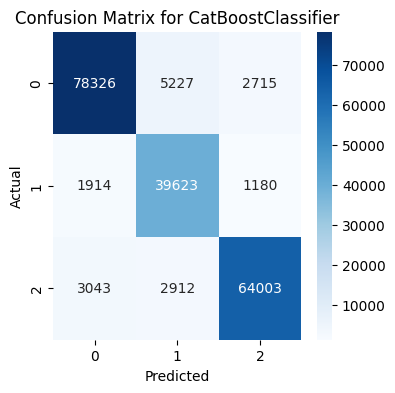

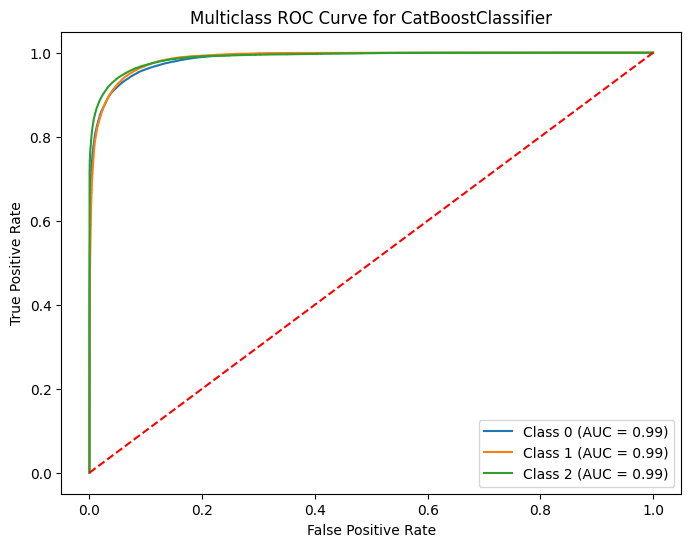

Classification Report for CatBoostClassifier:

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     86268
           1       0.83      0.93      0.88     42717
           2       0.94      0.91      0.93     69958

    accuracy                           0.91    198943
   macro avg       0.90      0.92      0.91    198943
weighted avg       0.92      0.91      0.92    198943

Train Score: 0.92
Test Score: 0.91



Model Performance Comparison:
                     model  Accuracy  \
0      LogisticRegression      0.60   
1  DecisionTreeClassifier      0.97   
2  RandomForestClassifier      0.94   
3           XGBClassifier      0.91   
4      CatBoostClassifier      0.91   

                                             ROC AUC  
0  {0: 0.7798316407991653, 1: 0.7244621057615879,...  
1  {0: 0.9768472611019788, 1: 0.9674468957347504,...  
2  {0: 0.9937432540936796, 1: 0.9936171812489685,...  
3  {0: 0.9853710447416721, 1: 0.9848152452605512

In [45]:
# Calculate class weights for a multiclass target
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

models = [
    LogisticRegression(class_weight='balanced', random_state=42),
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    XGBClassifier(objective='multi:softprob',num_class=len(np.unique(y)),random_state=42),
    CatBoostClassifier(auto_class_weights='Balanced', random_state=42, loss_function='MultiClass', verbose=0),
]

results_df, best_model = best_classification_model(X_scaled, y, models)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtc.fit(x_train, y_train)

y_val_pred = dtc.predict(x_test)

# Evaluate performance
print("Validation Set Classification Report :")
print(classification_report(y_test, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2']))

Validation Set Classification Report :
              precision    recall  f1-score   support

     Class 0       0.97      0.97      0.97     86268
     Class 1       0.95      0.95      0.95     42717
     Class 2       0.97      0.97      0.97     69958

    accuracy                           0.97    198943
   macro avg       0.96      0.96      0.96    198943
weighted avg       0.97      0.97      0.97    198943



# Cross Validation & Hyper Parameter Tuning


In [ ]:
# Use StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Initialize classifiers
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Define scoring metric (e.g., F1-score)
scoring = make_scorer(f1_score, average='weighted')

# Perform cross-validation for RandomForest
rf_cv_scores = cross_val_score(rf_model, X_scaled, y, cv=sss, scoring=scoring, n_jobs=-1)
print("RandomForest F1 Cross-Validation Scores:", rf_cv_scores)
print("RandomForest Mean F1 Score:", rf_cv_scores.mean())

# Perform cross-validation for DecisionTree
dt_cv_scores = cross_val_score(dt_model, X_scaled, y, cv=sss, scoring=scoring, n_jobs=-1)
print("DecisionTree F1 Cross-Validation Scores:", dt_cv_scores)
print("DecisionTree Mean F1 Score:", dt_cv_scores.mean())


RandomForest F1 Cross-Validation Scores: [0.90038308 0.8982213  0.89411707 0.90407994 0.90374111]
RandomForest Mean F1 Score: 0.900108499882446
DecisionTree F1 Cross-Validation Scores: [0.87522993 0.8717833  0.87170961 0.87177175 0.87058126]
DecisionTree Mean F1 Score: 0.8722151701898924


In [57]:
def objective(trial):
    # Load dataset (for example, Iris dataset)
    data = load_iris()
    X, y = data.data, data.target
    
    max_depth = trial.suggest_int('max_depth', 1, 10, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced'])
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6, step=1)

    # Create and evaluate the model
    model = DecisionTreeClassifier(max_depth=max_depth, 
                                   min_samples_split=min_samples_split, 
                                   criterion=criterion, class_weight=class_weight, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(model, X, y, n_jobs=-1, cv=3, scoring='accuracy').mean()
    
    return score

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best Parameters:", study.best_params)  # Correct attribute to access the best parameters
print("Best Score:", study.best_value)  # Best score achieved by those parameters


[I 2024-12-06 21:50:35,845] A new study created in memory with name: no-name-4936ea97-ed24-4f58-b480-34936e1d1409
[I 2024-12-06 21:50:39,244] Trial 0 finished with value: 0.9466666666666667 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'criterion': 'gini', 'class_weight': 'balanced', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9466666666666667.
[I 2024-12-06 21:50:40,450] Trial 1 finished with value: 0.94 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9466666666666667.
[I 2024-12-06 21:50:41,528] Trial 2 finished with value: 0.94 and parameters: {'max_depth': 10, 'min_samples_split': 7, 'criterion': 'entropy', 'class_weight': 'balanced', 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9466666666666667.
[I 2024-12-06 21:50:42,667] Trial 3 finished with value: 0.94 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'criterion': 'gini', 'clas

Best Parameters: {'max_depth': 4, 'min_samples_split': 7, 'criterion': 'gini', 'class_weight': 'balanced', 'min_samples_leaf': 3}
Best Score: 0.96


In [ ]:
def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200]),
        'max_depth': trial.suggest_int('max_depth', 10, 40),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }

    # Initialize the RandomForest model
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    
    # Cross-validation score
    scores = cross_val_score(rf_model, X_scaled, y, cv=3, scoring='f1_weighted')
    return scores.mean()

# Create and optimize study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Output the best parameters and score
print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)


[I 2024-12-06 21:52:33,208] A new study created in memory with name: no-name-7905d407-bdb6-41de-bbed-a4565f6ee55e
[I 2024-12-06 22:02:47,124] Trial 0 finished with value: 0.7929565600589643 and parameters: {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'log2', 'class_weight': None}. Best is trial 0 with value: 0.7929565600589643.
[I 2024-12-06 22:16:26,763] Trial 1 finished with value: 0.854563394080833 and parameters: {'n_estimators': 200, 'max_depth': 36, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.854563394080833.
[I 2024-12-06 22:27:00,482] Trial 2 finished with value: 0.867372129363047 and parameters: {'n_estimators': 100, 'max_depth': 39, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.867372129363047.
[I 2024-12-06 22:41:05,074] Trial 3 finished with value:

Best Parameters: {'n_estimators': 200, 'max_depth': 37, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}
Best Score: 0.8714257862943295


**Cross Validation Scores for best models**<br>
RandomForest F1 Cross-Validation Scores: [0.90038308 0.8982213  0.89411707 0.90407994 0.90374111]<br>
RandomForest Mean F1 Score: 0.900108499882446<br>
DecisionTree F1 Cross-Validation Scores: [0.87522993 0.8717833  0.87170961 0.87177175 0.87058126]<br>
DecisionTree Mean F1 Score: 0.8722151701898924<br><br>

**Hyper Parameters for Decision Tree Classifier**<br>
*Best Parameters:* {'max_depth': 4, 'min_samples_split': 7, 'criterion': 'gini', 'class_weight': 'balanced', 'min_samples_leaf': 3}
*Best Score:* 0.96

**Hyper Parameters for Random Forest Classifier**<br>
*Best Parameters:* {'n_estimators': 200, 'max_depth': 37, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'class_weight': None}
*Best Score:* 0.8714257862943295

# Delete all variables before Final Model

In [35]:
# Delete all variables in the kernel, except for system variables
variables_to_delete = [var for var in globals() if not var.startswith("_")]

# Delete the variables safely
for var in variables_to_delete:
    del globals()[var]


# FINAL MODEL

**Imports and Methods for Final Model**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import gc
from typing import Tuple, Dict, Iterator
import joblib
import gc
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    confusion_matrix, classification_report,
    roc_auc_score
)


def get_optimal_dtypes(df_sample):
    """Determine optimal dtypes based on a data sample to minimize memory usage."""
    dtypes = {}
    for col in df_sample.columns:
        if pd.api.types.is_integer_dtype(df_sample[col]):
            if df_sample[col].min() > -128 and df_sample[col].max() < 128:
                dtypes[col] = 'int8'
            elif df_sample[col].min() > -32768 and df_sample[col].max() < 32767:
                dtypes[col] = 'int16'
            else:
                dtypes[col] = 'int32'
        elif pd.api.types.is_float_dtype(df_sample[col]):
            dtypes[col] = 'float32'
        else:
            dtypes[col] = df_sample[col].dtype  # Retain original dtype for non-numeric columns
    return dtypes


def load_and_clean_data(file_path, chunk_size=100000):
    """
    Load data efficiently and handle high-null columns in chunks.
    Identifies high-null columns and performs memory-efficient processing.
    """
    print(f"Analyzing null percentages from {file_path}...")
    sample = pd.read_csv(file_path, nrows=chunk_size, low_memory=False)

    dtypes = get_optimal_dtypes(sample)

    # Identify high-null columns
    null_percentage = sample.isnull().mean() * 100
    high_null_columns = null_percentage[null_percentage >= 70].index.tolist()
    print(f"Found {len(high_null_columns)} columns with > 70% null values")

    # Additional columns to drop
    columns_to_drop = list(set(high_null_columns + ['Timestamp', 'Usage', 'MitreTechniques']))
    if 'IncidentGrade' in columns_to_drop:
        columns_to_drop.remove('IncidentGrade')  # Ensure target column is not dropped
    print(f"Dropping columns: {columns_to_drop}")

    # Process file in chunks
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=chunk_size, dtype=dtypes, low_memory=False):

        # Drop unnecessary columns
        chunk.drop(columns=[col for col in columns_to_drop if col in chunk.columns], inplace=True)

        # Handle object columns by converting low-cardinality ones to categorical
        for col in chunk.select_dtypes(include=['object']).columns:
            if len(chunk[col].unique()) / len(chunk) < 0.5:
                chunk[col] = chunk[col].astype('category')
        
        chunks.append(chunk)
    
    df = pd.concat(chunks, ignore_index=True)
    del chunks
    gc.collect()
    return df


def process_data_with_pca(X, n_components=0.95, chunk_size=10000):
    """Process data with StandardScaler and IncrementalPCA in memory-efficient chunks"""   
    # Initialize StandardScaler
    print("Fitting StandardScaler...")
    scaler = StandardScaler()
    
    # First pass: Compute mean and variance in chunks
    for start_idx in range(0, len(X), chunk_size):
        end_idx = min(start_idx + chunk_size, len(X))
        chunk = X.iloc[start_idx:end_idx]
        scaler.partial_fit(chunk)
    
    # Transform data in chunks and store in a memmap to save RAM
    print("Transforming data with StandardScaler...")
    X_scaled = np.memmap('temp_scaled.mmap', dtype='float32', mode='w+',
                         shape=(X.shape[0], X.shape[1]))
    
    for start_idx in range(0, len(X), chunk_size):
        end_idx = min(start_idx + chunk_size, len(X))
        chunk = X.iloc[start_idx:end_idx]
        X_scaled[start_idx:end_idx] = scaler.transform(chunk)
    
    # Use PCA to estimate the number of components needed
    # print("Determining the number of components to retain desired variance...")
    # pca = PCA(n_components=n_components)
    # pca.fit(X_scaled[:min(10000, len(X))])  # Fit on a subset for efficiency
    # n_components_ = pca.n_components_
    # print(f"Number of components to retain {n_components * 100}% variance: {n_components_}")
    n_components_=60
    # Fit IncrementalPCA with determined n_components
    print("Fitting IncrementalPCA...")
    ipca = IncrementalPCA(n_components=n_components_)
    
    for start_idx in range(0, len(X), chunk_size):
        end_idx = min(start_idx + chunk_size, len(X))
        ipca.partial_fit(X_scaled[start_idx:end_idx])
    
    # Transform data with IncrementalPCA in chunks
    print("Transforming data with IncrementalPCA...")
    X_pca = np.memmap('temp_pca.mmap', dtype='float32', mode='w+',
                      shape=(X.shape[0], ipca.n_components_))
    
    for start_idx in range(0, len(X), chunk_size):
        end_idx = min(start_idx + chunk_size, len(X))
        X_pca[start_idx:end_idx] = ipca.transform(X_scaled[start_idx:end_idx])
    
    # Convert memmap to numpy array and clean up
    X_pca_array = np.array(X_pca)
    del X_scaled, X_pca
    os.remove('temp_scaled.mmap')
    os.remove('temp_pca.mmap')
    gc.collect()
    
    print(f"Reduced dimensions from {X.shape[1]} to {X_pca_array.shape[1]}")
    return X_pca_array, scaler, ipca


def preprocess_data_chunked(df, target_col, chunk_size=1000):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import OneHotEncoder, LabelEncoder

    # Initialize lists to store processed chunks
    X_chunks = []
    y_chunks = []

    # Initialize label encoder for the target column
    le_target = LabelEncoder()

    # Initialize OneHotEncoder outside the loop
    global_oe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # For tracking all encoded column names across chunks
    all_encoded_columns = []

    for start_idx in range(0, len(df), chunk_size):
        end_idx = min(start_idx + chunk_size, len(df))
        chunk = df.iloc[start_idx:end_idx]

        # Check target column existence
        if target_col not in chunk.columns:
            print(f"Skipping chunk: target column {target_col} missing.")
            continue

        # Process target column
        y = chunk[target_col].replace({'': np.nan, 'None': np.nan, 'NULL': np.nan})
        mask = ~y.isna()

        chunk = chunk[mask].reset_index(drop=True)
        y = y[mask].reset_index(drop=True)

        if chunk.empty:
            print(f"Skipping chunk: no valid target values in range {start_idx}-{end_idx}.")
            continue

        # Separate features
        X = chunk.drop(columns=[target_col])
        drop_cols = ['Timestamp', 'Usage', 'MitreTechniques']
        X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)

        # One-hot encode categorical columns
        categorical_columns = ['Category', 'EntityType', 'EvidenceRole']
        valid_cat_cols = [col for col in categorical_columns if col in X.columns]

        if len(valid_cat_cols) > 0:
            # Fit the global encoder only once
            if len(all_encoded_columns) == 0:
                global_oe.fit(df[valid_cat_cols])
                all_encoded_columns = global_oe.get_feature_names_out(valid_cat_cols)

            # Encode chunk
            encoded_data = global_oe.transform(X[valid_cat_cols])
            encoded_df = pd.DataFrame(
                encoded_data,
                columns=global_oe.get_feature_names_out(valid_cat_cols),
                index=X.index
            )

            # Ensure all columns are aligned by reindexing
            encoded_df = encoded_df.reindex(columns=all_encoded_columns, fill_value=0)

            # Drop original categorical columns and concatenate encoded columns
            X.drop(columns=valid_cat_cols, inplace=True)
            X = pd.concat([X, encoded_df], axis=1)


        # Drop specific columns post-encoding
        drop_cols = ['EntityType_Container', 'EntityType_ContainerImage',
                     'EntityType_KubernetesPod', 'EntityType_ContainerRegistry',
                     'Category_Weaponization']
        X.drop(columns=[col for col in drop_cols if col in X.columns], inplace=True)

        # Encode the target column
        y_encoded = pd.Series(le_target.fit_transform(y), index=y.index)

        # Append processed chunk
        X_chunks.append(X)
        y_chunks.append(y_encoded)

    # Concatenate chunks
    X = pd.concat(X_chunks, ignore_index=True) if X_chunks else pd.DataFrame()
    y = pd.concat(y_chunks, ignore_index=True) if y_chunks else pd.Series(dtype='float')

    # Final null check
    # print(f"Final X null values: {X.isna().sum().sum()}, y null values: {y.isna().sum()}")
    print(f"Final X shape: {X.shape}, y shape: {y.shape}")
    
    return X, y


class ChunkedDataset:
    """Handles large datasets by processing them in chunks"""
    def __init__(self, X, y, chunk_size=10000):
        self.X = X
        self.y = y
        self.chunk_size = chunk_size
        self.n_samples = len(X)
        self.n_classes = len(np.unique(y))
    
    def chunks(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        """Yield chunks of data"""
        for start in range(0, self.n_samples, self.chunk_size):
            end = min(start + self.chunk_size, self.n_samples)
            yield self.X[start:end], self.y[start:end]
            
    def get_chunk_predictions(self, model) -> Iterator[np.ndarray]:
        """Get predictions for chunks"""
        for X_chunk, _ in self.chunks():
            yield model.predict_proba(X_chunk)
            gc.collect()

class ImbalancedMulticlassModel:
    def __init__(self, use_rf: bool = True, chunk_size: int = 10000):
        self.chunk_size = chunk_size
        
        # Calculate class weights based on the full dataset
        if use_rf:
            self.model = RandomForestClassifier(
                n_estimators=200,
                n_jobs=-1,
                max_depth=19,
                min_samples_split=3,
                min_samples_leaf=3,
                max_features='sqrt',
                class_weight='balanced', 
                random_state=42,
                verbose=1
            )
        else:
            self.model = DecisionTreeClassifier(
                
                criterion='entropy',
                max_depth=None,
                class_weight='balanced',
                max_features=None,
                min_samples_leaf=2, 
                min_samples_split=2,
                random_state=42
            )

    def train_and_predict(
        self,
        train_x: np.ndarray,
        train_y: np.ndarray,
        test_x: np.ndarray,
        test_y: np.ndarray,
        model_save_path: str = None
    ) -> Tuple[np.ndarray, Dict]:
        # Create chunked datasets
        train_data = ChunkedDataset(train_x, train_y, self.chunk_size)
        test_data = ChunkedDataset(test_x, test_y, self.chunk_size)
        
        # Get number of classes
        self.n_classes = len(np.unique(train_y))
        print(f"Number of classes detected: {self.n_classes}")
        
        # Print class distribution
        for i in range(self.n_classes):
            count = np.sum(train_y == i)
            percentage = (count / len(train_y)) * 100
            print(f"Class {i}: {count} samples ({percentage:.2f}%)")
        
        print("\nTraining model on chunked data...")
        self.model.fit(train_x, train_y)
        
        if model_save_path:
            print(f"Saving model to {model_save_path}")
            joblib.dump(self.model, model_save_path)
        
        # Get predictions in chunks
        print("Getting predictions...")
        train_probs = np.vstack([chunk for chunk in train_data.get_chunk_predictions(self.model)])
        test_probs = np.vstack([chunk for chunk in test_data.get_chunk_predictions(self.model)])
        test_pred = self.model.predict(test_x)
        
        # Plot evaluations
        metrics = self._plot_evaluation(
            train_y, train_probs,
            test_y, test_pred, test_probs
        )
        
        return test_pred, metrics
    
    def _plot_evaluation(
        self,
        train_y: np.ndarray,
        train_probs: np.ndarray,
        test_y: np.ndarray,
        test_pred: np.ndarray,
        test_probs: np.ndarray
    ) -> Dict:
        # Prepare one-vs-rest binary labels for ROC curves
        train_bin = label_binarize(train_y, classes=range(self.n_classes))
        test_bin = label_binarize(test_y, classes=range(self.n_classes))
        
        # Plot results
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 2)
        
        # ROC Curves (one-vs-rest)
        ax1 = fig.add_subplot(gs[0, :])
        colors = plt.cm.rainbow(np.linspace(0, 1, self.n_classes))
        
        # Plot ROC curve for each class
        for i, color in zip(range(self.n_classes), colors):
            # Train ROC
            fpr, tpr, _ = roc_curve(train_bin[:, i], train_probs[:, i])
            train_roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, color=color, linestyle=':',
                    label=f'Train ROC class {i} (AUC = {train_roc_auc:.2f})')
            
            # Test ROC
            fpr, tpr, _ = roc_curve(test_bin[:, i], test_probs[:, i])
            test_roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, color=color,
                    label=f'Test ROC class {i} (AUC = {test_roc_auc:.2f})')
        
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_title('One-vs-Rest ROC Curves')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax1.grid(True)
        
        # Confusion Matrix with normalization
        ax2 = fig.add_subplot(gs[1, 0])
        cm = confusion_matrix(test_y, test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
        ax2.set_title('Confusion Matrix (Raw Counts)')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('Actual')
        
        # Normalized Confusion Matrix
        ax3 = fig.add_subplot(gs[1, 1])
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax3)
        ax3.set_title('Confusion Matrix (Normalized)')
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')
                
        plt.tight_layout()
        plt.show()
        
        # Print detailed classification report
        print("\nClassification Report:")
        print(classification_report(test_y, test_pred))
        
        # Calculate macro-averaged ROC AUC
        macro_roc_auc = roc_auc_score(test_bin, test_probs, average='macro')
        weighted_roc_auc = roc_auc_score(test_bin, test_probs, average='weighted')
        
        # Clear memory
        plt.close()
        gc.collect()
        
        return {
            'confusion_matrix': cm,
            'normalized_confusion_matrix': cm_norm,
            'macro_avg_auc': macro_roc_auc,
            'weighted_avg_auc': weighted_roc_auc
        }

def evaluate_model(test_y, test_pred, test_probs, n_classes):
    # Prepare one-vs-rest binary labels for ROC curves
    test_bin = label_binarize(test_y, classes=range(n_classes))

    # Plot results
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2)
    
    # ROC Curves (one-vs-rest)
    ax1 = fig.add_subplot(gs[0, :])
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))
    
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(test_bin[:, i], test_probs[:, i])
        test_roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, color=color, label=f'Test ROC class {i} (AUC = {test_roc_auc:.2f})')
    
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_title('One-vs-Rest ROC Curves')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)
    
    # Confusion Matrix
    ax2 = fig.add_subplot(gs[1, 0])
    cm = confusion_matrix(test_y, test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix (Raw Counts)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    ax3 = fig.add_subplot(gs[1, 1])
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax3)
    ax3.set_title('Confusion Matrix (Normalized)')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(test_y, test_pred))
    
    # Macro and Weighted AUC
    macro_roc_auc = roc_auc_score(test_bin, test_probs, average='macro')
    weighted_roc_auc = roc_auc_score(test_bin, test_probs, average='weighted')
    print(f"Macro-averaged AUC: {macro_roc_auc:.3f}")
    print(f"Weighted-averaged AUC: {weighted_roc_auc:.3f}")

def main_processing_pipeline():
    """Main pipeline to process both train and test datasets."""
    print("Loading and cleaning training data...")
    train_df = load_and_clean_data('Data_sets/GUIDE_Train.csv')

    print("Preprocessing training data...")
    train_X, train_y = preprocess_data_chunked(train_df, 'IncidentGrade')
    del train_df
    gc.collect()

    print("Applying PCA to training data...")
    train_X_pca, scaler, pca = process_data_with_pca(train_X)
    del train_X
    gc.collect()

    print("Loading and cleaning test data...")
    test_df = load_and_clean_data('Data_sets/GUIDE_Test.csv')

    print("Preprocessing test data...")
    test_X, test_y = preprocess_data_chunked(test_df, 'IncidentGrade')
    del test_df
    gc.collect()

    test_X_pca = pca.transform(scaler.transform(test_X))
    del test_X
    gc.collect()
    print("Transformed test data.")
    return train_X_pca, train_y, test_X_pca, test_y

def train_and_evaluate(
    train_x,
    train_y,
    test_x,
    test_y,
    use_rf=True,
    chunk_size=10000,
    model_save_path=None
):
    model = ImbalancedMulticlassModel(use_rf=use_rf, chunk_size=chunk_size)
    predictions, metrics = model.train_and_predict(
        train_x, train_y,
        test_x, test_y,
        model_save_path
    )
    return predictions, metrics


**Pre_Processing Pipeline**

In [31]:
train_X_pca, train_y, test_X_pca, test_y = main_processing_pipeline()

Loading and cleaning training data...
Analyzing null percentages from Data_sets/GUIDE_Train.csv...
Found 9 columns with > 70% null values
Dropping columns: ['LastVerdict', 'AntispamDirection', 'SuspicionLevel', 'Roles', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Usage', 'ActionGrouped', 'ResourceType', 'MitreTechniques', 'Timestamp']
Preprocessing training data...
Final X shape: (9465497, 80), y shape: (9465497,)
Applying PCA to training data...
Fitting StandardScaler...
Transforming data with StandardScaler...
Fitting IncrementalPCA...
Transforming data with IncrementalPCA...
Reduced dimensions from 80 to 60
Loading and cleaning test data...
Analyzing null percentages from Data_sets/GUIDE_Test.csv...
Found 9 columns with > 70% null values
Dropping columns: ['LastVerdict', 'AntispamDirection', 'SuspicionLevel', 'Roles', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Usage', 'ActionGrouped', 'ResourceType', 'MitreTechniques', 'Timestamp']
Preprocessing test data...
Final

**Using Decision Tree Classifier for Prediciting**

Number of classes detected: 3
Class 0: 4110817 samples (43.43%)
Class 1: 2031967 samples (21.47%)
Class 2: 3322713 samples (35.10%)

Training model on chunked data...
Saving model to multiclass_model_dt.joblib
Getting predictions...


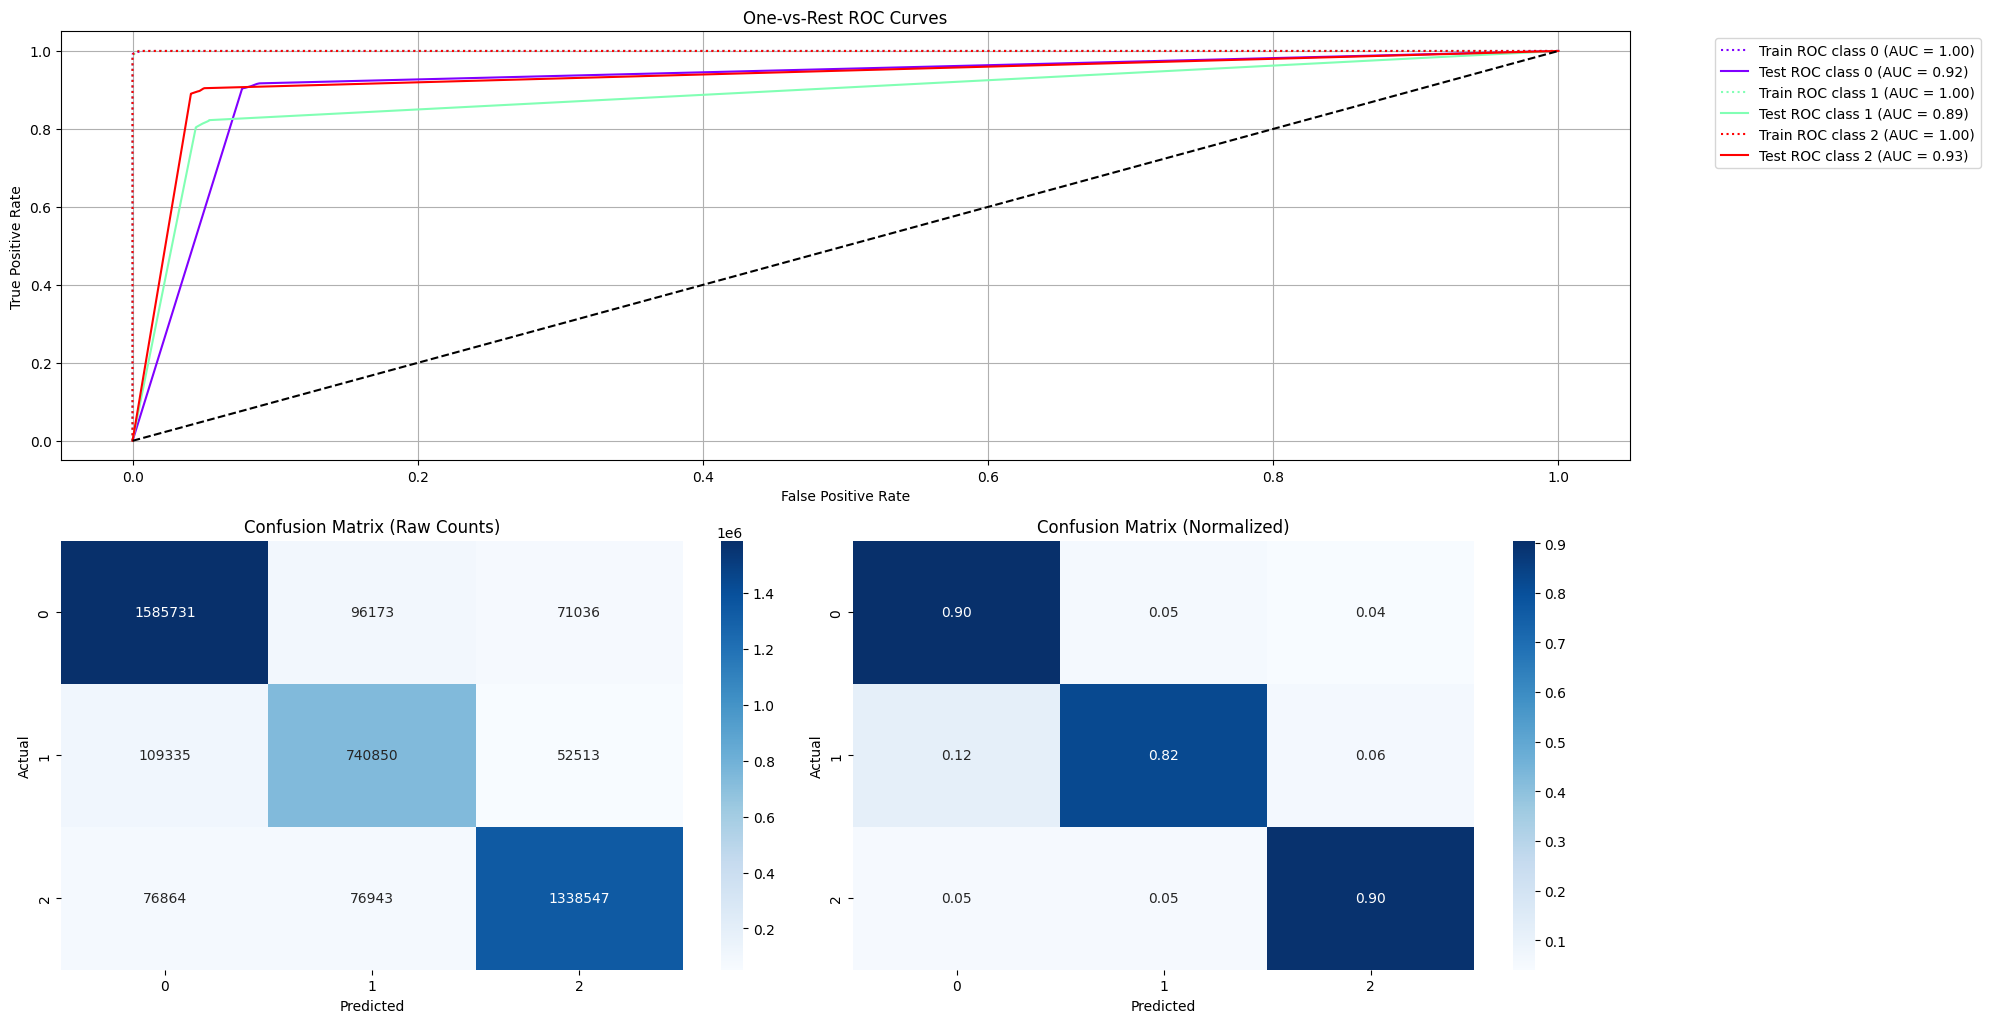


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90   1752940
           1       0.81      0.82      0.82    902698
           2       0.92      0.90      0.91   1492354

    accuracy                           0.88   4147992
   macro avg       0.87      0.87      0.87   4147992
weighted avg       0.88      0.88      0.88   4147992

Macro-averaged AUC: 0.913
Weighted-averaged AUC: 0.916


In [34]:
predictions, metrics = train_and_evaluate(
    train_X_pca, train_y, test_X_pca, test_y,
    use_rf=False,
    chunk_size=100000,
    model_save_path='multiclass_model_dt.joblib'
)

# Access specific metrics
print(f"Macro-averaged AUC: {metrics['macro_avg_auc']:.3f}")
print(f"Weighted-averaged AUC: {metrics['weighted_avg_auc']:.3f}")

**Using Random Forest Classifier for Prediciting**

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   27.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   30.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   28.2s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   31.5s finished


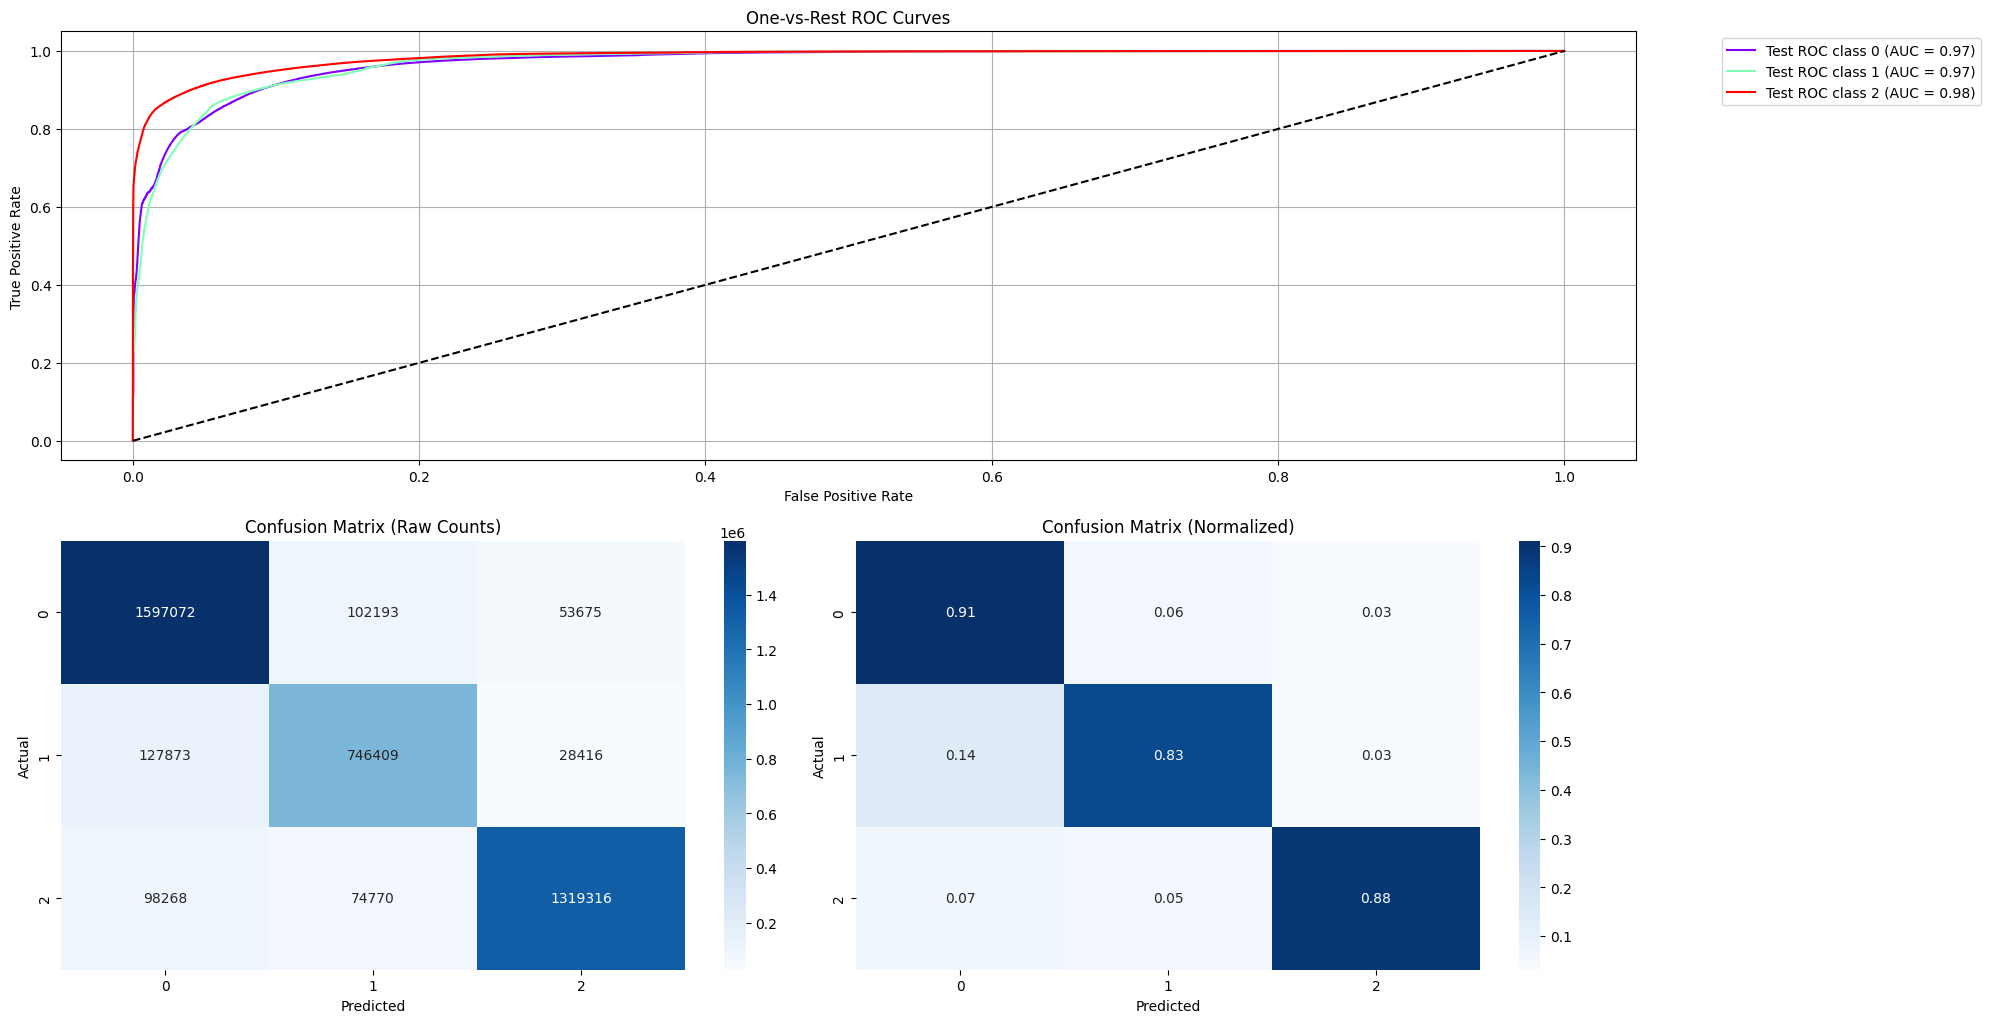


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89   1752940
           1       0.81      0.83      0.82    902698
           2       0.94      0.88      0.91   1492354

    accuracy                           0.88   4147992
   macro avg       0.88      0.87      0.87   4147992
weighted avg       0.88      0.88      0.88   4147992

Macro-averaged AUC: 0.975
Weighted-averaged AUC: 0.975


In [ ]:
predictions, metrics = train_and_evaluate(
    train_X_pca, train_y, test_X_pca, test_y,
    use_rf=True,
    chunk_size=100000,
    model_save_path='multiclass_model_rf.joblib'
)

# Access specific metrics
print(f"Macro-averaged AUC: {metrics['macro_avg_auc']:.3f}")
print(f"Weighted-averaged AUC: {metrics['weighted_avg_auc']:.3f}")

# Execute trained model

Training the model will take longer time for Random Forest.<br>
Alternatively, we can use the joblib file and predict.<br><br>
*Note: main_processing_pipeline() needed to be executed before.*

In [ ]:
# Load the trained model
models_joblib = ['multiclass_model_dt.joblib', 'multiclass_model_rf.joblib']

for joblib_file in models_joblib:
    model = joblib.load(joblib_file)

    # Predict probabilities and classes
    test_probs = model.predict_proba(test_X_pca)
    test_pred = model.predict(test_X_pca)

    # Call the evaluation function
    n_classes = len(np.unique(test_y))
    evaluate_model(test_y, test_pred, test_probs, n_classes)


# FINAL REPORT

## **Overview**
This report compares the performance of **Random Forest Classifier** and **Decision Tree Classifier** after hyperparameter tuning and optimization, evaluated on a large, imbalanced multiclass dataset.

---

## **Performance Metrics**

<div style="display: flex; justify-content: center; align-items: flex-start;">

<div style="flex: 0 0 48%; padding-right: 10px;">

### **Decision Tree Classifier**  

| Class | Precision | Recall | F1-Score | Support  |
|-------|-----------|--------|----------|----------|
| 0     | 0.89      | 0.90   | 0.90     | 1,752,940 |
| 1     | 0.81      | 0.82   | 0.82     | 902,698   |
| 2     | 0.92      | 0.90   | 0.91     | 1,492,354 |

- **Overall Accuracy**: 88%
- **Macro Average**:
  - Precision: 0.87
  - Recall: 0.87
  - F1-Score: 0.87
- **Weighted Average**:
  - Precision: 0.88
  - Recall: 0.88
  - F1-Score: 0.88
- **Macro-Averaged AUC**: 0.913
- **Weighted-Averaged AUC**: 0.916

</div>

<div style="flex: 0 0 4%;">

<!-- Divider Line -->
<hr style="height: 100%; width: 1px; background-color: #000; border: none;">

</div>

<div style="flex: 0 0 48%; padding-left: 10px;">

### **Random Forest Classifier**  

| Class | Precision | Recall | F1-Score | Support  |
|-------|-----------|--------|----------|----------|
| 0     | 0.88      | 0.91   | 0.89     | 1,752,940 |
| 1     | 0.81      | 0.83   | 0.82     | 902,698   |
| 2     | 0.94      | 0.88   | 0.91     | 1,492,354 |

- **Overall Accuracy**: 88%
- **Macro Average**:
  - Precision: 0.88
  - Recall: 0.87
  - F1-Score: 0.87
- **Weighted Average**:
  - Precision: 0.88
  - Recall: 0.88
  - F1-Score: 0.88
- **Macro-Averaged AUC**: 0.975
- **Weighted-Averaged AUC**: 0.975

</div>

</div>



## **Visualizations**

### **ROC Curves**


#### **Random Forest Classifier**:
The **ROC curve** for the Random Forest model demonstrates its ability to separate the classes effectively, with an **AUC of 0.975**. The model performs well across all classes.

![Multiclass ROC Curve - RF](Screenshots/Random_forest_ROC.jpg)

#### **Decision Tree Classifier**:
The **ROC curve** for the Decision Tree model shows a slightly lower **AUC of 0.913**, but it still performs well in class separation.

![Multiclass ROC Curve - DT](Screenshots/Decision_tree_ROC.jpg)

---
### **Confusion Matrix**

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; align-items: start; text-align: center;">


  <div>
        <h3>Random Forest Classifier</h3>
        <div style="display: flex; flex-direction: column; align-items: center;">
            <img src="Screenshots/Random_forest_results_raw.jpg" alt="Confusion Matrix RF - Raw" 
                 style="width: 100%; max-width: 500px; height: auto;" />
            <div style="padding-bottom: 20px;"></div> <!-- Padding below first set -->
            <img src="Screenshots/Random_forest_results_norm.jpg" alt="Confusion Matrix RF - Normalized" 
                 style="width: 100%; max-width: 500px; height: auto;" />
        </div>
  </div>
  <div>
        <h3>Decision Tree Classifier</h3>
        <div style="display: flex; flex-direction: column; align-items: center;">
            <img src="Screenshots/Decision_Tree_results_raw.jpg" alt="Confusion Matrix DT - Raw" 
                 style="width: 100%; max-width: 500px; height: auto;" />
            <div style="padding-bottom: 50px;"></div> <!-- Padding below first set -->
            <img src="Screenshots/Decision_Tree_results_norm.jpg" alt="Confusion Matrix DT - Normalized" 
                 style="width: 100%; max-width: 500px; height: auto;" />
        </div>
  </div>

</div>
---

## **Key Insights**

- **Random Forest Classifier**:
  - Higher **Macro-Averaged AUC (0.975)** compared to the Decision Tree model (0.913).
  - Performs better with **higher recall for Class 0** (0.91) and **Class 2** (0.88).
  - Slightly better performance on **Class 1** in terms of recall (0.83).
  
- **Decision Tree Classifier**:
  - Slightly lower **AUC (0.913)** compared to Random Forest but still a strong performer.
  - Performs slightly better in terms of **precision** for **Class 0** (0.89) and **Class 2** (0.92).
  - The **simplicity** of the Decision Tree makes it a **faster model**.

- **Both Models**:
  - Handle **imbalanced classes** effectively.
  - Show good **performance across all classes** with minor differences in recall for **Class 1**.

---

## **Conclusion**

- **Random Forest Classifier** is the **preferred model** due to its higher **AUC scores** and **better recall** for the minority class.
- **Decision Tree Classifier** is an alternative, suitable for **faster computations** or simpler applications where model interpretability is key.

Both models demonstrate robustness in handling multiclass imbalanced datasets and are ready for deployment.

---

*Generated on: Dec 5 2024*
